<a href="https://colab.research.google.com/github/Foluwa/HDR_Group_8_Tech_Challenge/blob/main/notebooks/FOLU_HDRUK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=cc34ee58ad690df27d10e5920d8162e84d12e9232367bac5cec59434e6eecd39
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zipfile import ZipFile
from scipy import stats
from lifelines import KaplanMeierFitter
import warnings

In [3]:
warnings.filterwarnings('ignore')
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (18, 14)

# Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and unzip datasets

In [5]:
# Version 2
!cp "/content/drive/My Drive/simulacrum_v2.1.0.zip" .
!unzip simulacrum_v2.1.0.zip

Archive:  simulacrum_v2.1.0.zip
   creating: simulacrum_v2.1.0/
   creating: simulacrum_v2.1.0/Data/
  inflating: simulacrum_v2.1.0/Data/sim_av_gene.csv  
  inflating: simulacrum_v2.1.0/Data/sim_av_patient.csv  
  inflating: simulacrum_v2.1.0/Data/sim_av_tumour.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_combined.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_episode.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_exposure.csv  
  inflating: simulacrum_v2.1.0/Data/sim_rtds_prescription.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_cycle.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_drug_detail.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_outcome.csv  
  inflating: simulacrum_v2.1.0/Data/sim_sact_regimen.csv  
   creating: simulacrum_v2.1.0/Documents/
  inflating: simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx  
  inflating: simulacrum_v2.1.0/Documents/Simulacrum_2_data_dictionaryVer2.1.0_2016-2019.xlsx  
  inflating: simulacrum_v2.1.0/LICENSE.txt  
 

In [6]:
# Version 1
!cp "/content/drive/My Drive/simulacrum_release_v1.2.0.2017.zip" .
!unzip simulacrum_release_v1.2.0.2017.zip

Archive:  simulacrum_release_v1.2.0.2017.zip
   creating: simulacrum_release_v1.2.0.2017/data/
  inflating: simulacrum_release_v1.2.0.2017/data/sim_av_patient.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_av_tumour.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_sact_cycle.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_sact_drug_detail.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_sact_outcome.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_sact_patient.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_sact_regimen.csv  
  inflating: simulacrum_release_v1.2.0.2017/data/sim_sact_tumour.csv  
   creating: simulacrum_release_v1.2.0.2017/data_dictionary_files/
  inflating: simulacrum_release_v1.2.0.2017/data_dictionary_files/all_z_lookup_tables.xlsx  
  inflating: simulacrum_release_v1.2.0.2017/data_dictionary_files/simulacrum_data_dictionary.xlsx  
  inflating: simulacrum_release_v1.2.0.2017/data_dictionary_files/zace27s

## Load datasets

In [7]:
DATA_DIR = "./simulacrum_v2.1.0/Data/"
LOOKUP_PATH = "./simulacrum_v2.1.0/Documents/all_z_lookup_tables.xlsx"

# Load Datasets

In [8]:
patient_df = pd.read_csv(os.path.join(DATA_DIR, "sim_av_patient.csv"))
tumour_df = pd.read_csv(os.path.join(DATA_DIR, "sim_av_tumour.csv"))
gene_df = pd.read_csv(os.path.join(DATA_DIR, "sim_av_gene.csv"))
sact_regimen_df = pd.read_csv(os.path.join(DATA_DIR, "sim_sact_regimen.csv"))
rtds_df = pd.read_csv(os.path.join(DATA_DIR, "sim_rtds_combined.csv"))

# Exploratory Data Analysis

### Data Type Distribution

In [9]:
def plot_data_type_distribution(df):
    dtype_counts = df.dtypes.value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(dtype_counts.values, labels=dtype_counts.index.astype(str), autopct='%1.1f%%')
    plt.title('Data Types Distribution')
    plt.tight_layout()
    plt.show()

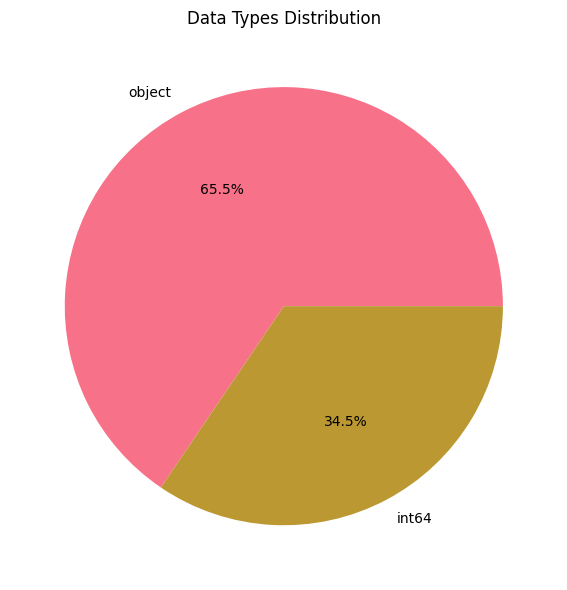

In [10]:
plot_data_type_distribution(gene_df)

### Missing Values

In [11]:
def plot_missing_data_bar(df):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    if not missing_counts.empty:
        missing_counts.plot(kind='bar', figsize=(12, 6))
        plt.title('Missing Values by Column')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No missing values in dataset.")

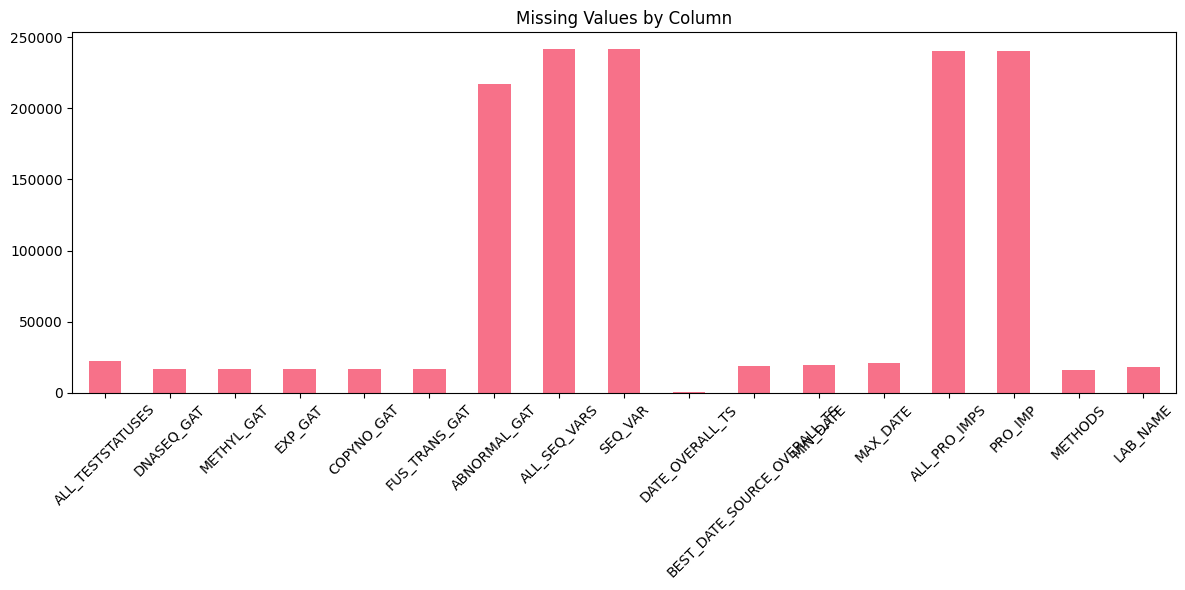

In [12]:
plot_missing_data_bar(gene_df)

### Correlation Matrix

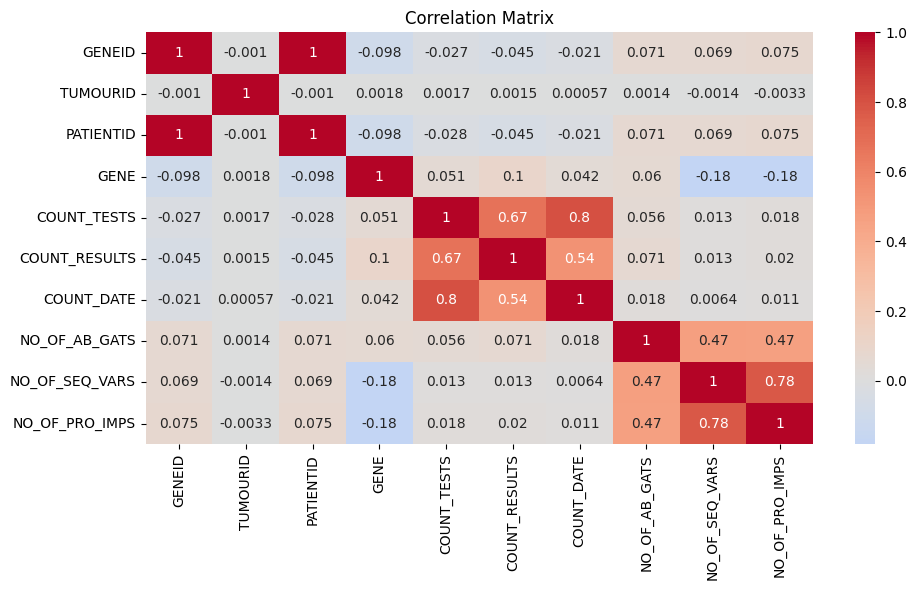

In [13]:
def plot_correlation_heatmap(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        correlation_matrix = df[numeric_cols].corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.tight_layout()
        plt.show()

plot_correlation_heatmap(gene_df)

### Descriptive Stats

In [14]:
def descriptive_stats(df):
    print("=== DESCRIPTIVE STATISTICS ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        display(df[numeric_cols].describe())

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        for col in categorical_cols[:5]:
            print(df[col].value_counts().head())

In [15]:
descriptive_stats(gene_df)

=== DESCRIPTIVE STATISTICS ===


,GENEID,TUMOURID,PATIENTID,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,NO_OF_AB_GATS,NO_OF_SEQ_VARS,NO_OF_PRO_IMPS
count,2.557280e+05,2.557280e+05,2.557280e+05,255728.000000,255728.000000,255728.000000,255728.000000,255728.000000,255728.000000,255728.000000
mean,1.284858e+08,1.100198e+07,1.284447e+08,1620.353907,1.075702,1.194066,1.052079,0.152803,0.059012,0.063536
std,4.383299e+07,5.778875e+05,4.383137e+07,1826.906918,0.357117,0.522050,0.281153,0.365673,0.250324,0.265658
min,1.003062e+07,1.000004e+07,1.006501e+07,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000676e+08,1.050088e+07,1.000210e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.300239e+08,1.100175e+07,1.300031e+08,67.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.301043e+08,1.150299e+07,1.300164e+08,2808.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.500094e+08,1.199998e+07,2.500025e+08,5101.000000,23.000000,23.000000,23.000000,3.000000,5.000000,5.000000


GENE_DESC
CD274 (PD-L1)    33891
EGFR             30441
ALK              22246
MLH1             20305
MSH6             20183
Name: count, dtype: int64
ALL_TESTSTATUSES
b:normal             153030
a:abnormal            28623
b:normal,b:normal     21198
c:borderline           6543
e:failed               4791
Name: count, dtype: int64
OVERALL_TS
b:normal          180092
a:abnormal         36346
g:unknown/null     25244
c:borderline        7804
e:failed            5460
Name: count, dtype: int64
DNASEQ_GAT
n:not_applicable_null    150755
b:normal_dna_sq           69214
a:abnormal_dna_sq         18831
c:borderline_a_dna_sq        20
Name: count, dtype: int64
METHYL_GAT
n:not_applicable_null    236092
b:normal_epi               1371
a:abnormal_methyl          1165
c:borderline_a_methyl       192
Name: count, dtype: int64


# v2

### Filter for Lung Cancer Only

In [16]:
lung_tumours = tumour_df[tumour_df["SITE_ICD10_O2_3CHAR"] == "C34"].copy()
lung_patient_ids = lung_tumours["PATIENTID"].unique()
lung_patients = patient_df[patient_df["PATIENTID"].isin(lung_patient_ids)].copy()

### Lookup Tables

In [17]:
xls = pd.ExcelFile(LOOKUP_PATH)
gender_lookup = pd.read_excel(xls, "z_gender").rename(columns={"Code": "GENDER", "Description": "gender_label"})
ethnicity_lookup = pd.read_excel(xls, "z_ethnicity").rename(columns={"Code": "ETHNICITY", "Description": "ethnicity_label"})
stage_lookup = pd.read_excel(xls, "z_stage").rename(columns={"Code": "STAGE_BEST", "Description": "stage_label"})

### Merge Lookup

In [18]:
lung_patients = lung_patients.merge(gender_lookup, on="GENDER", how="left")
lung_patients = lung_patients.merge(ethnicity_lookup, on="ETHNICITY", how="left")
lung_tumours = lung_tumours.merge(stage_lookup, on="STAGE_BEST", how="left")

In [19]:
# Prepare the survival DataFrame
df = lung_tumours.merge(
    lung_patients[['PATIENTID', 'VITALSTATUS', 'VITALSTATUSDATE']],
    on='PATIENTID', how='left'
)

df['DiagDate'] = pd.to_datetime(df['DIAGNOSISDATEBEST'])
df['EndDate'] = pd.to_datetime(df['VITALSTATUSDATE'])

df['followup_days'] = (df['EndDate'] - df['DiagDate']).dt.days.clip(lower=0)
df['event_observed'] = np.where(df['VITALSTATUS'] == 'D', 1, 0)

# Drop invalid or negative durations
df = df[df['followup_days'].notnull() & (df['followup_days'] >= 0)]

### Stage Group Simplification

In [20]:
def simplify_stage(code, label):
    if pd.notnull(label):
        return label
    return f"Stage {str(code)[0]}"

lung_tumours['Stage_Group'] = lung_tumours.apply(
    lambda row: simplify_stage(row['STAGE_BEST'], row.get('stage_label')), axis=1
)

In [21]:
# SACT uptake by Stage_Group
sact_patients = sact_regimen_df['ENCORE_PATIENT_ID'].unique()
stage_sact = lung_tumours.drop_duplicates('PATIENTID').assign(
    received_sact=lambda df: df['PATIENTID'].isin(sact_patients)
)

In [22]:
# Build a unique patient-level series for Stage_Group
stage_series = (
    lung_tumours
    .drop_duplicates('PATIENTID')
    .set_index('PATIENTID')['Stage_Group']
)

# # Now assign safely—stage_series has unique index
# df_surv = df.assign(
#     Stage_Group = df['PATIENTID'].map(stage_series)
# )


# # # Assign Stage_Group to the survival DataFrame
# # df_surv = df.assign(
# #     Stage_Group = df['PATIENTID'].map(stage_series)
# # )


In [23]:
# Assign Stage_Group to the survival DataFrame
df_surv = df.assign(
    Stage_Group = df['PATIENTID'].map(stage_series)
)

### Demographic Plots

In [24]:
def plot_counts(df, column, title, xlabel):
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

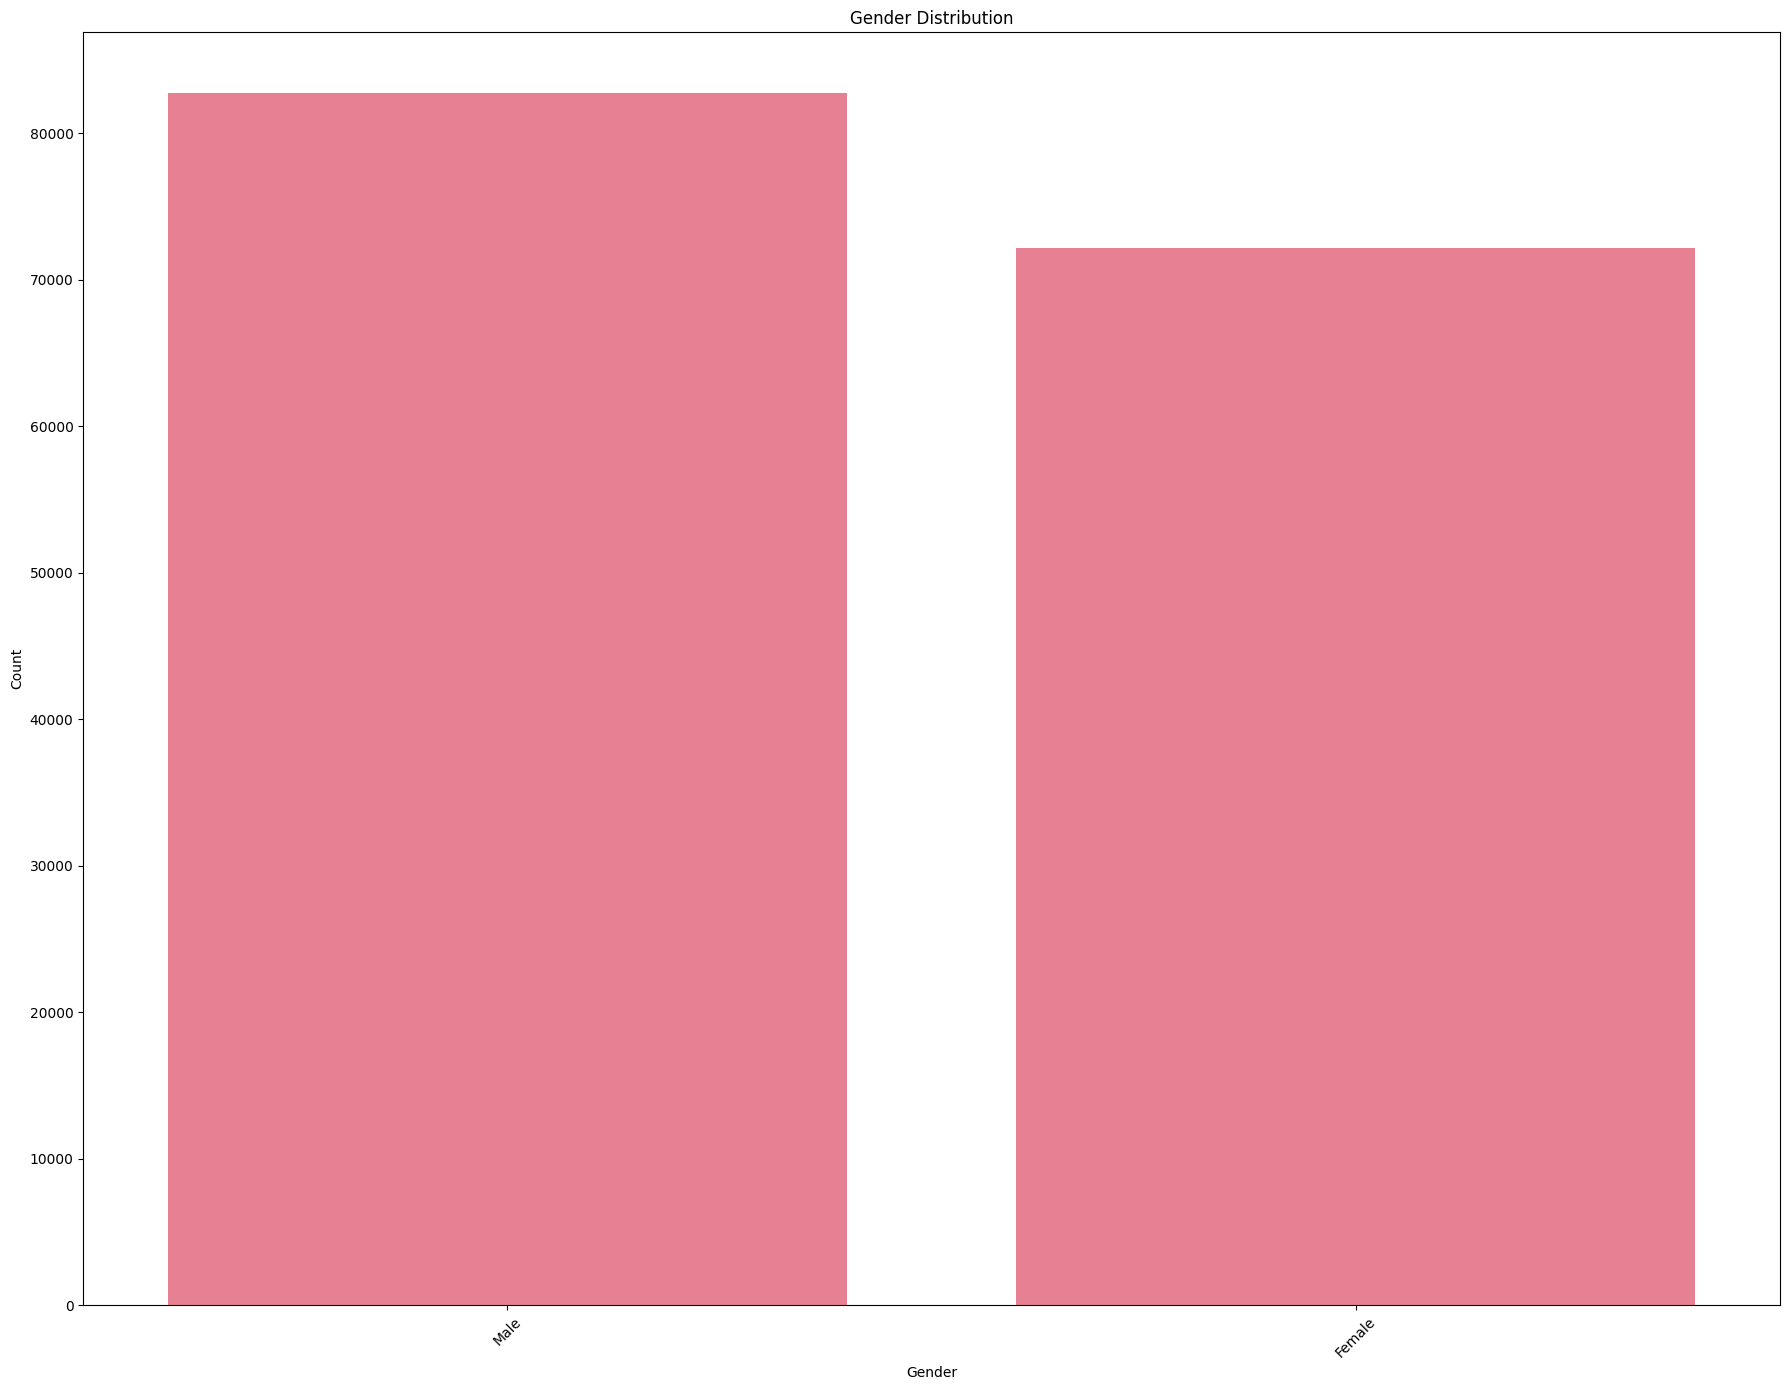

In [25]:
plot_counts(lung_patients, "gender_label", "Gender Distribution", "Gender")

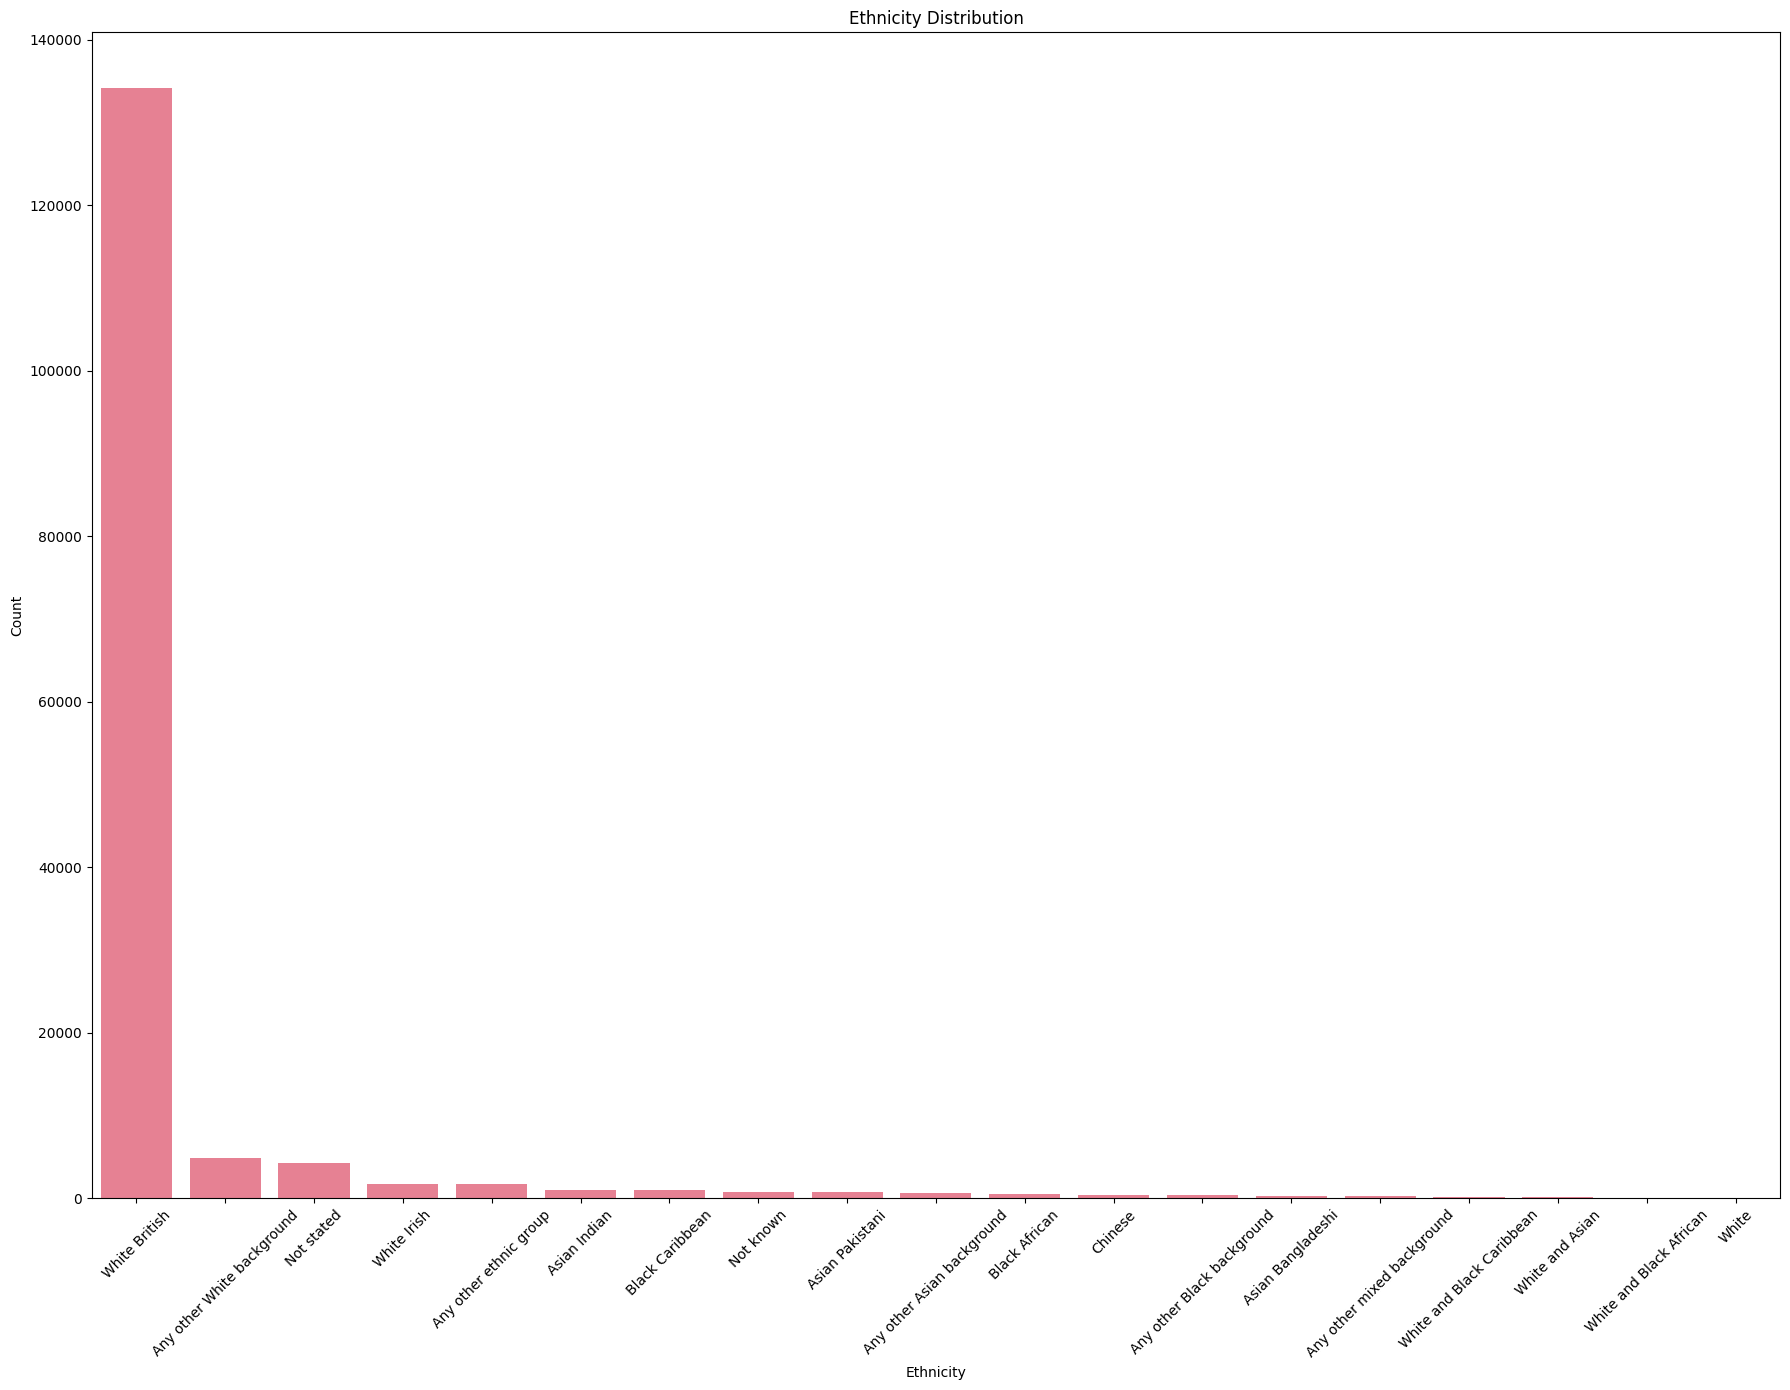

In [26]:
plot_counts(lung_patients, "ethnicity_label", "Ethnicity Distribution", "Ethnicity")

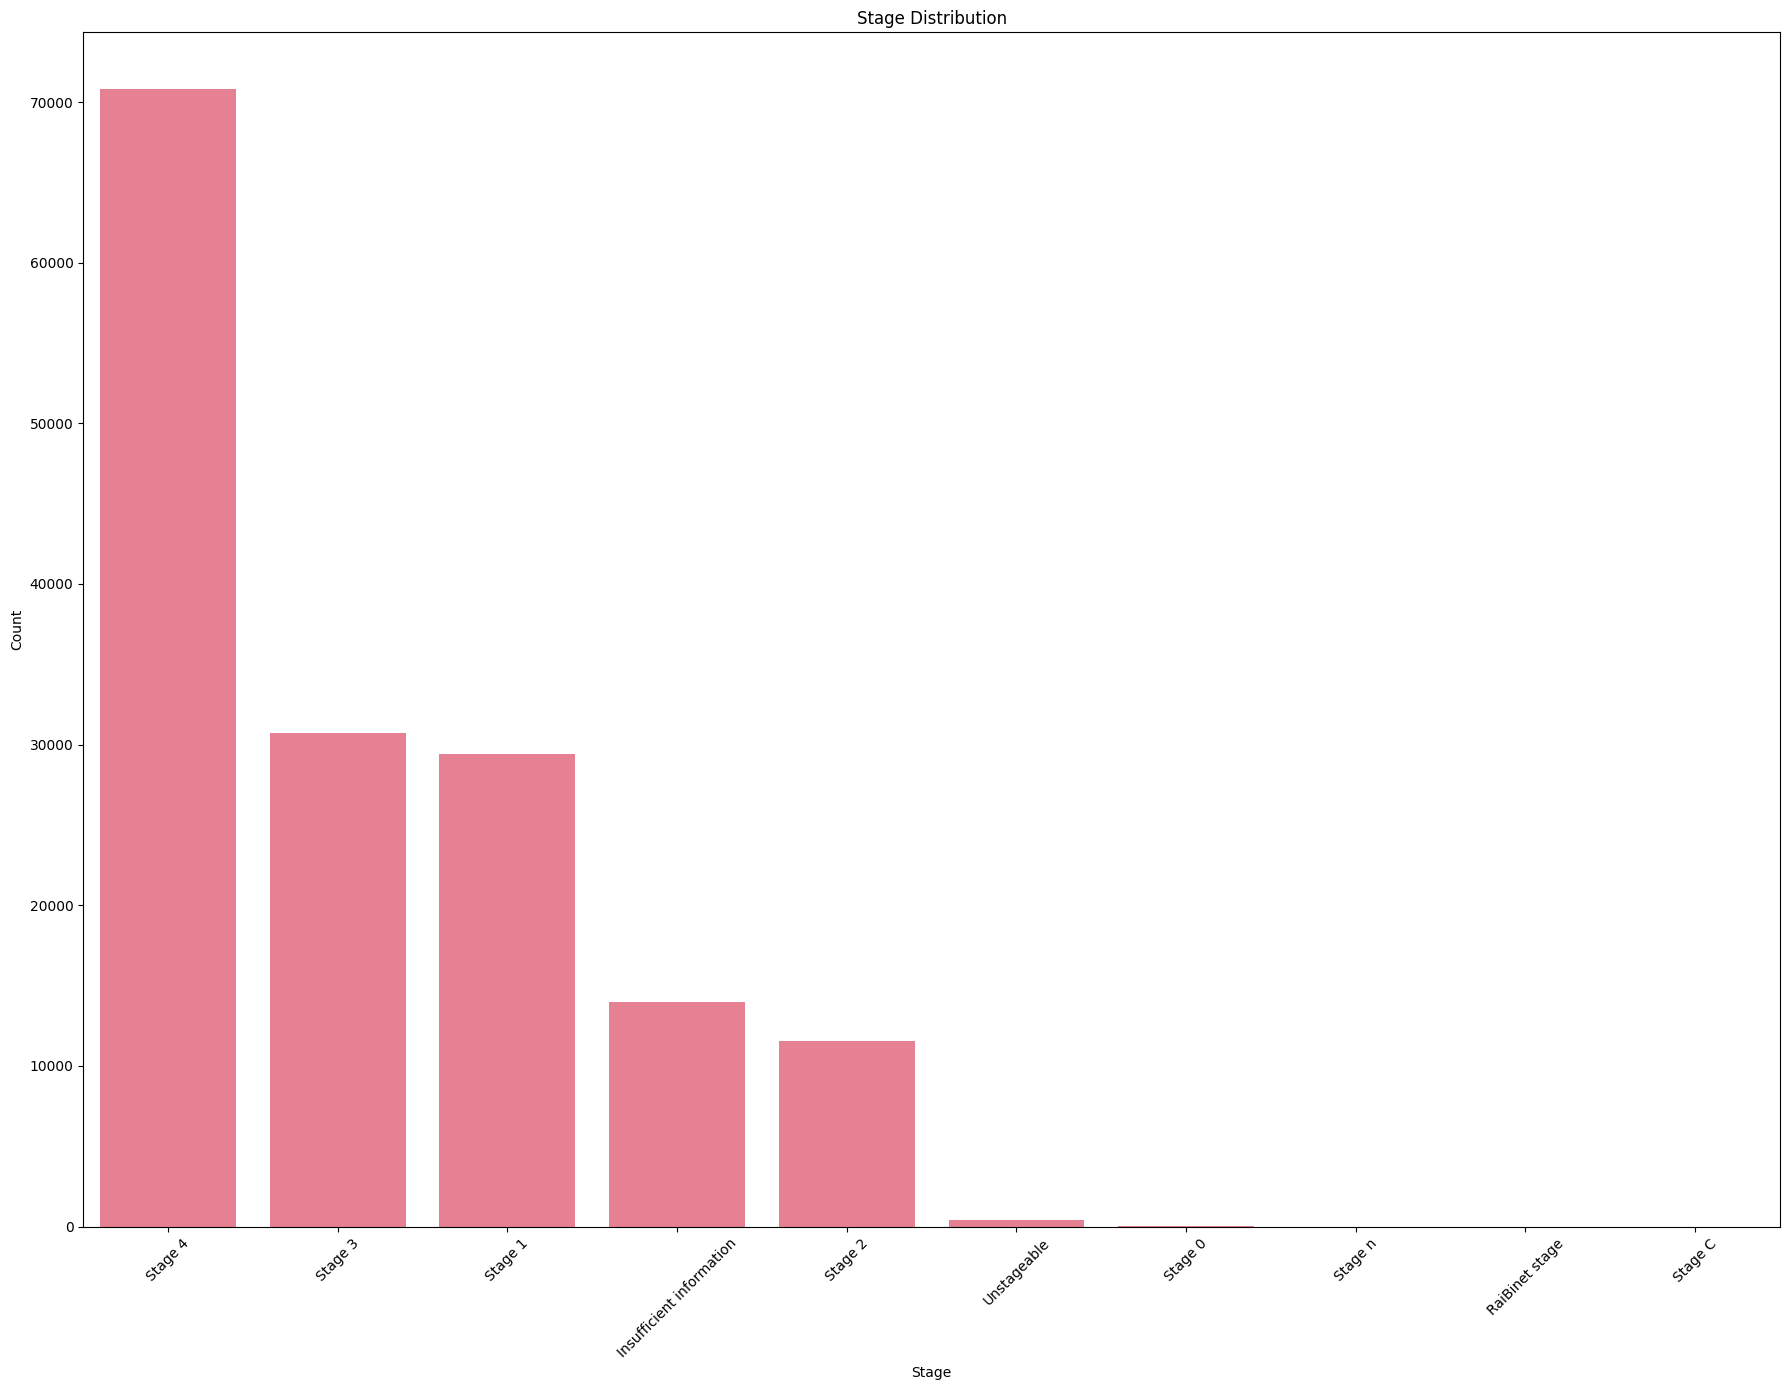

In [27]:
plot_counts(lung_tumours, "Stage_Group", "Stage Distribution", "Stage")

### Age Distribution

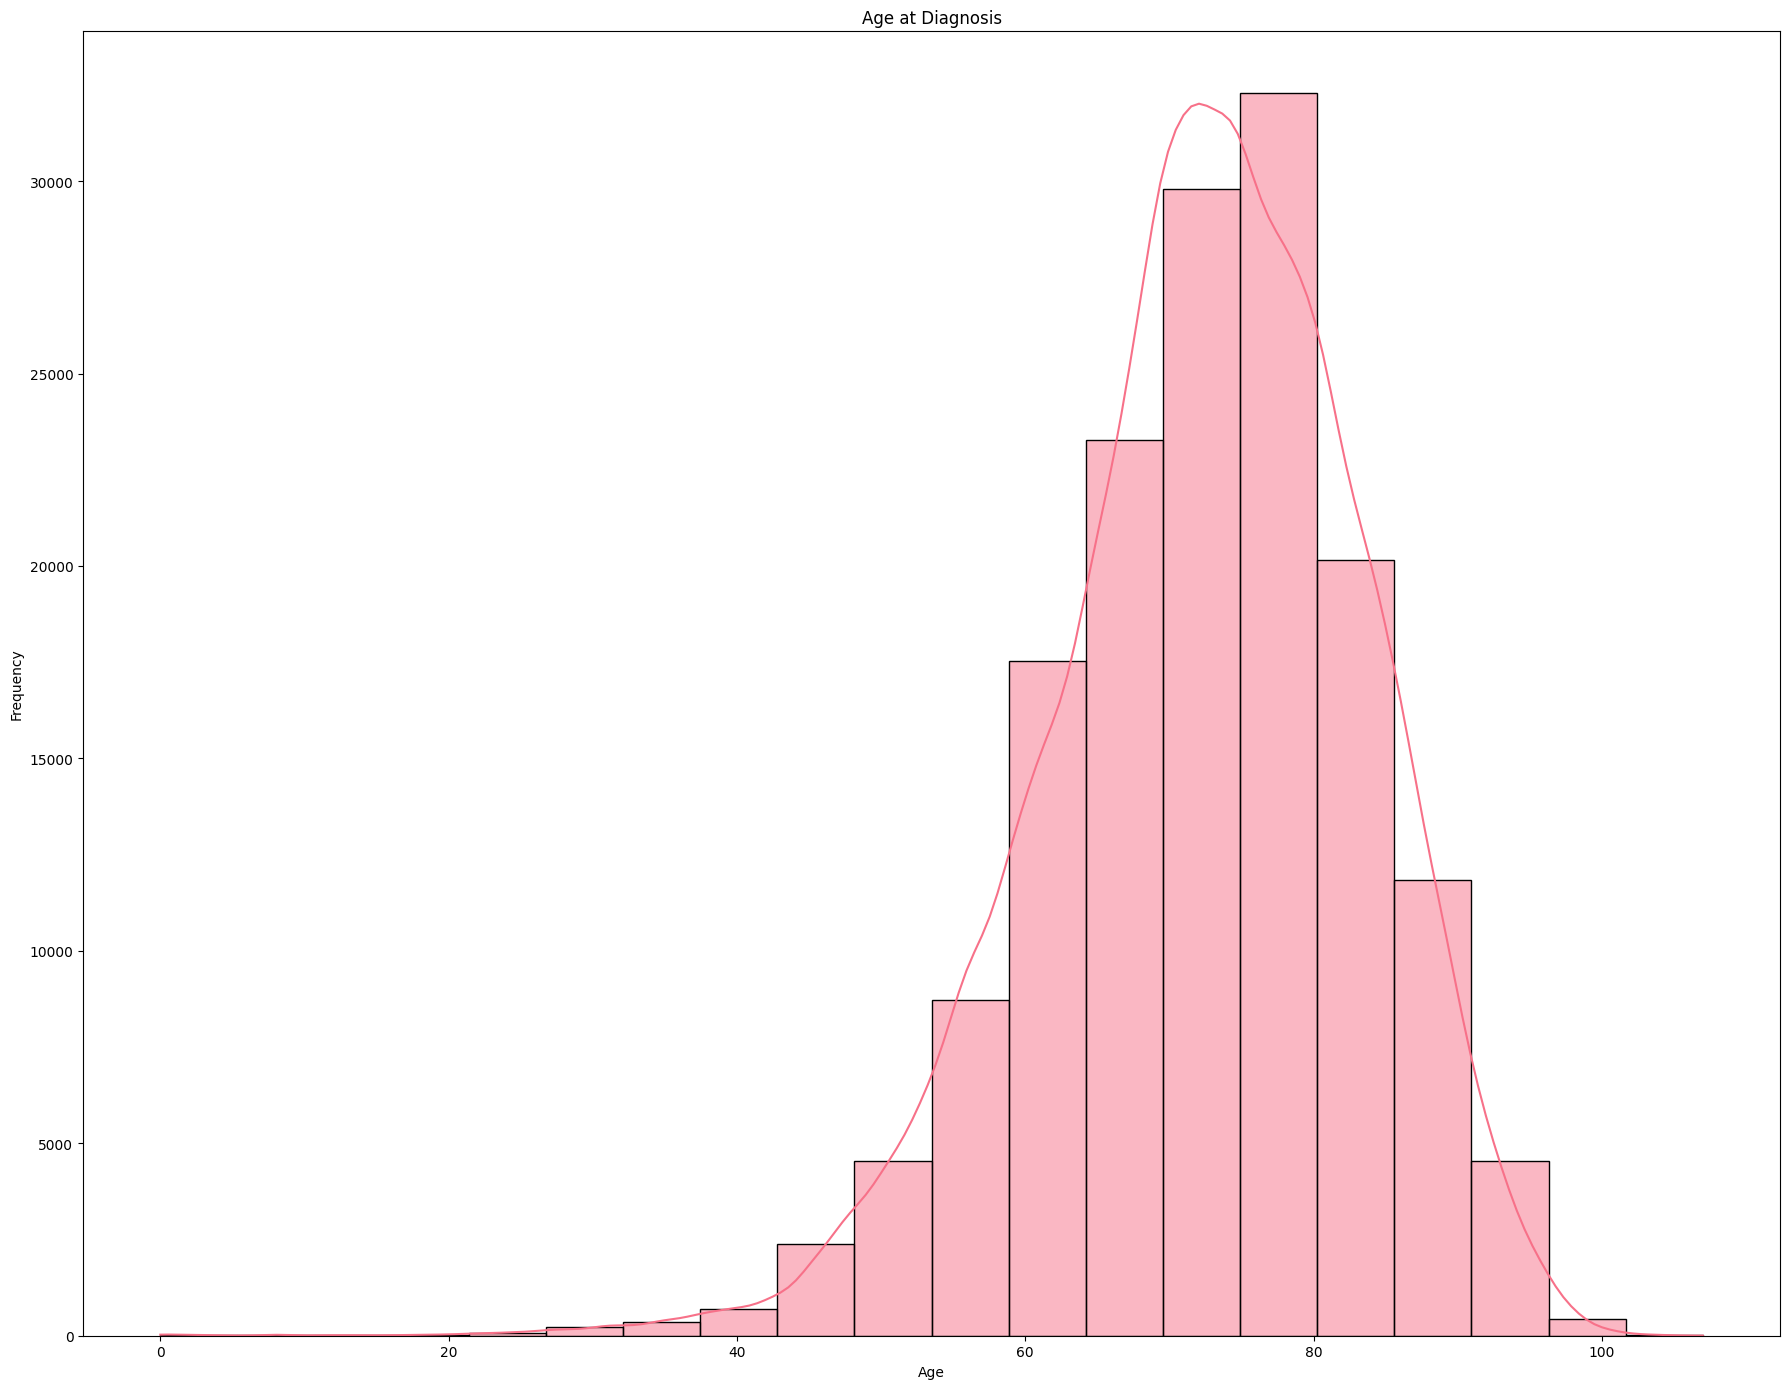

In [28]:
sns.histplot(lung_tumours["AGE"].dropna(), bins=20, kde=True)
plt.title("Age at Diagnosis")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Kaplan Meier Curves

In [29]:
kmf = KaplanMeierFitter()

#### Survival Proxy

In [30]:
surv_df = lung_tumours.merge(lung_patients[['PATIENTID', 'VITALSTATUS', 'VITALSTATUSDATE']], on='PATIENTID')
surv_df['DiagDate'] = pd.to_datetime(surv_df['DIAGNOSISDATEBEST'])
surv_df['EndDate'] = pd.to_datetime(surv_df['VITALSTATUSDATE'])
surv_df['followup_days'] = (surv_df['EndDate'] - surv_df['DiagDate']).dt.days.clip(lower=0)
surv_df['event_observed'] = (surv_df['VITALSTATUS'] == 'D').astype(int)
surv_df = surv_df[surv_df['followup_days'].notnull() & (surv_df['followup_days'] >= 0)]

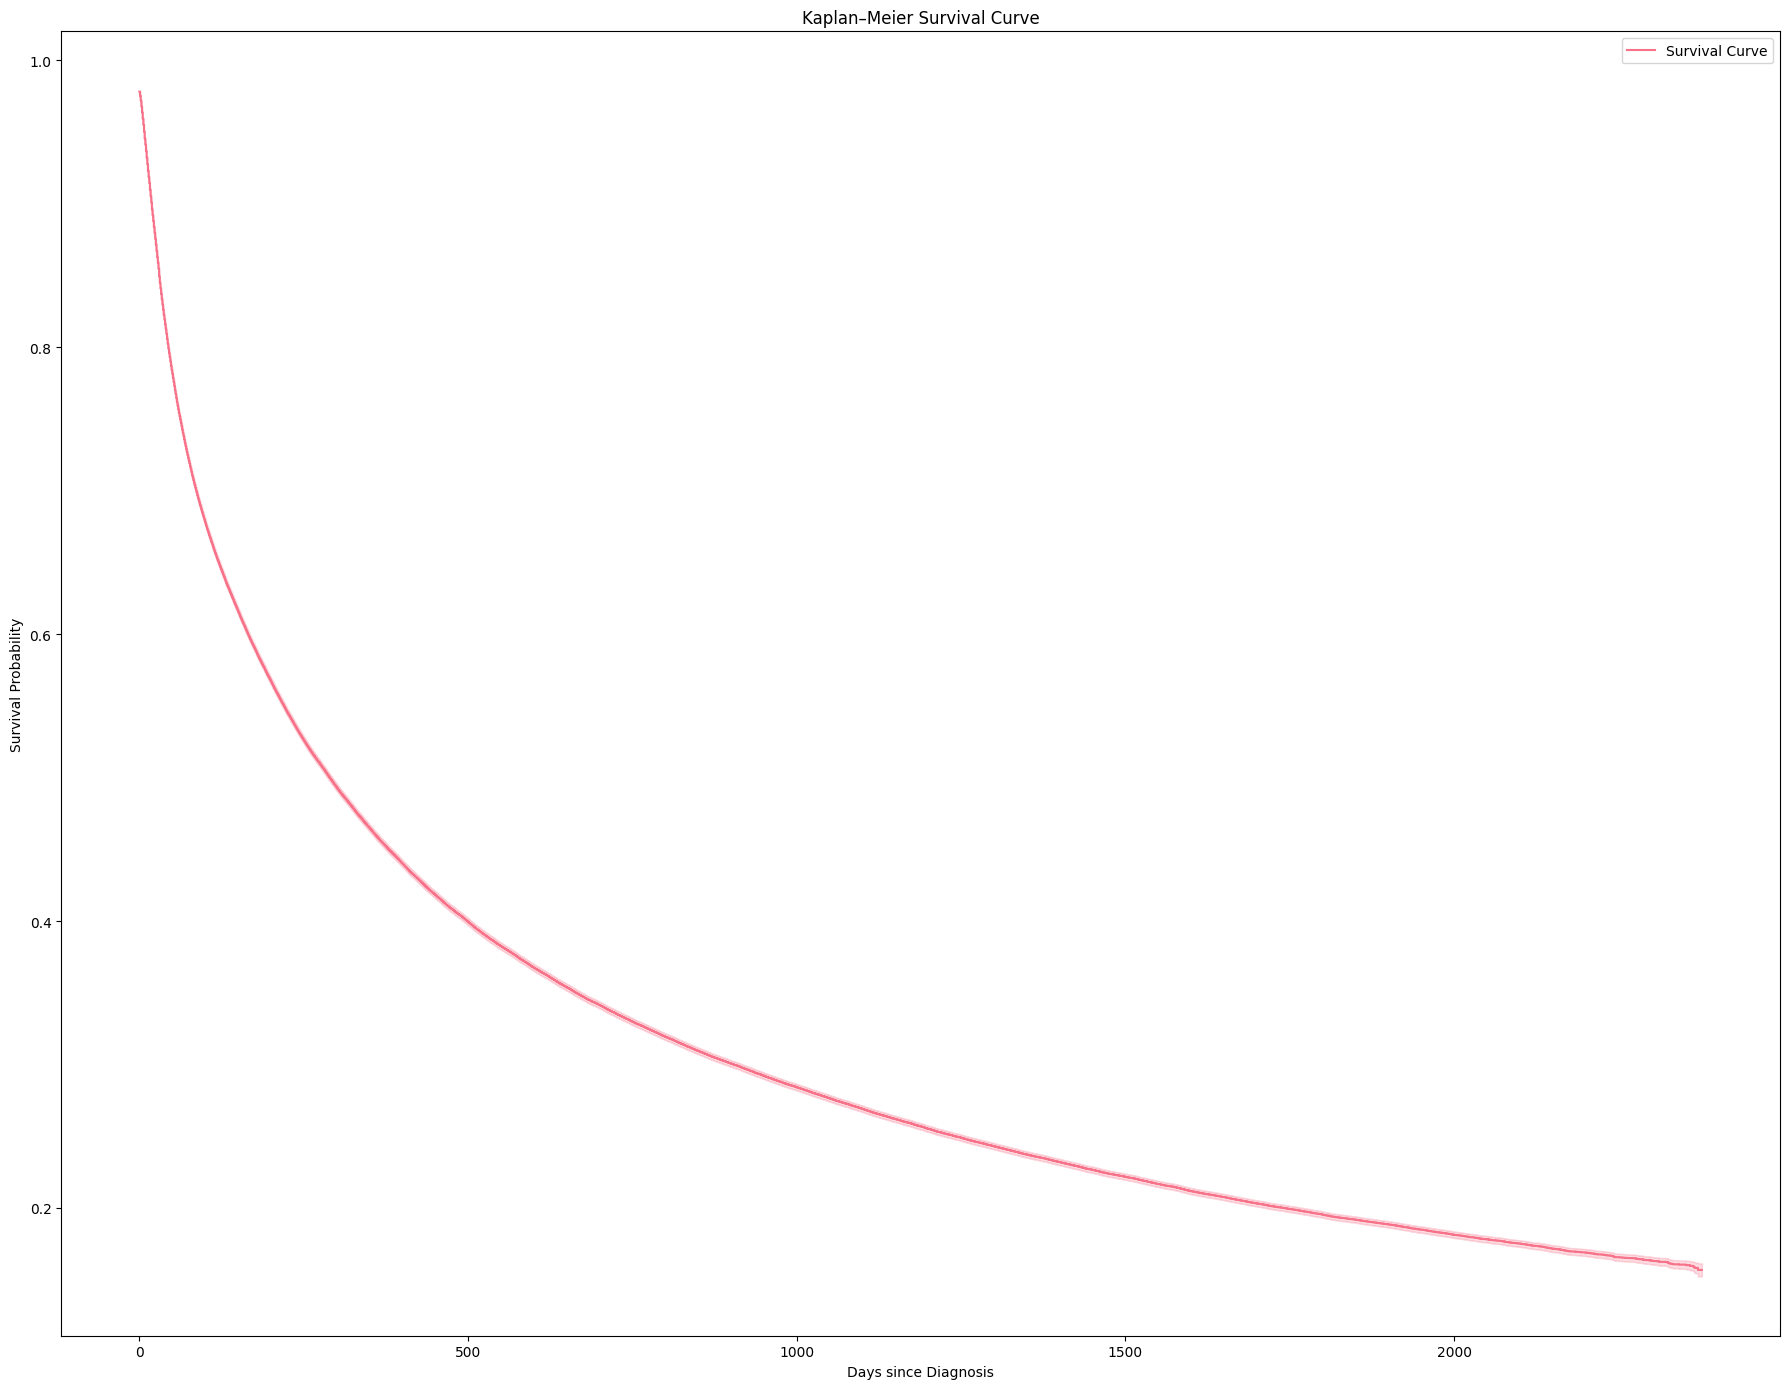

In [31]:
# kmf = KaplanMeierFitter()
kmf.fit(surv_df['followup_days'], event_observed=surv_df['event_observed'], label="Survival Curve")
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier Survival Curve")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()

#### Kaplan-Meier Curves by Tumour Stage

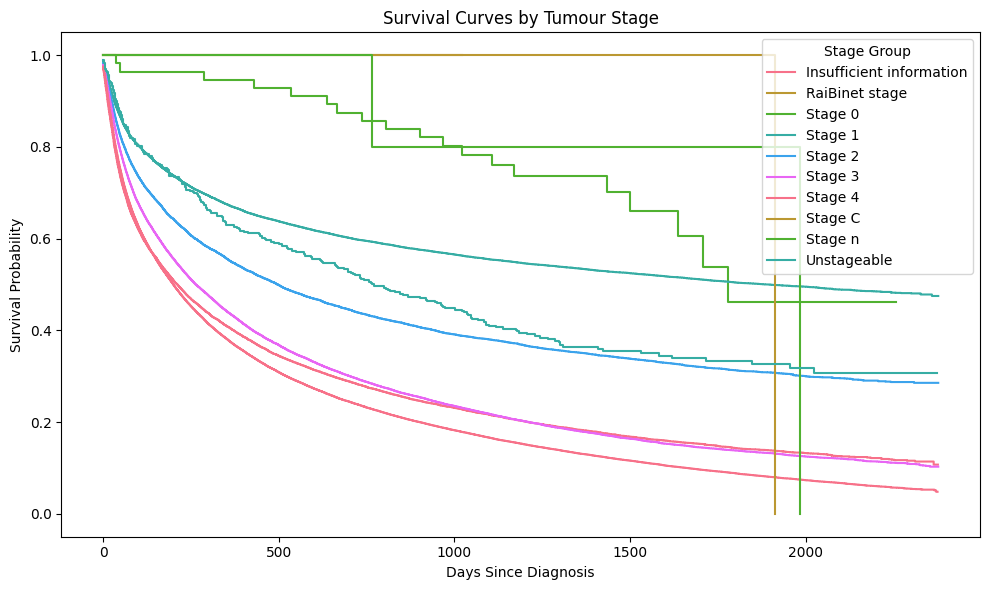

In [32]:
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for stage, group in df_surv.dropna(subset=['Stage_Group']).groupby('Stage_Group'):
    kmf.fit(group['followup_days'], group['event_observed'], label=stage)
    kmf.plot_survival_function(ci_show=False)

plt.title("Survival Curves by Tumour Stage")
plt.xlabel("Days Since Diagnosis")
plt.ylabel("Survival Probability")
plt.legend(title="Stage Group")
plt.tight_layout()
plt.show()

### Survival by Genetic Test Status + Stage (Grouped)

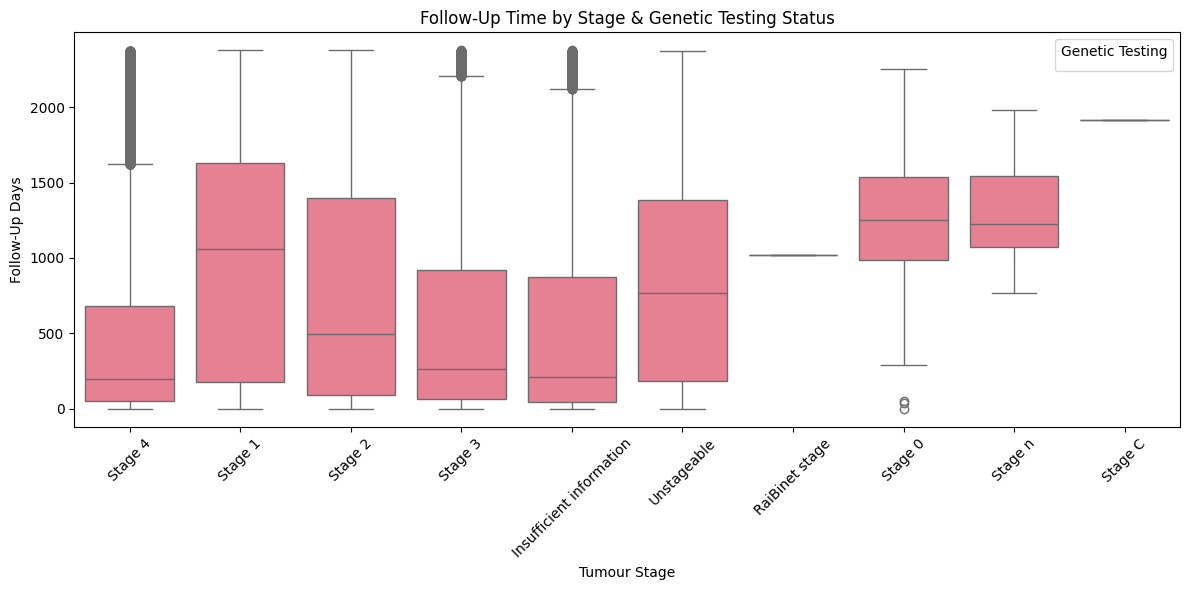

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_surv, x='Stage_Group', y='followup_days')
plt.title("Follow-Up Time by Stage & Genetic Testing Status")
plt.xlabel("Tumour Stage")
plt.ylabel("Follow-Up Days")
plt.xticks(rotation=45)
plt.legend(title="Genetic Testing")
plt.tight_layout()
plt.show()

### Radiotherapy Uptake

In [34]:
rt_intent_lookup = pd.read_excel(xls, sheet_name="z_radiotherapyintent")
rt_intent_lookup.columns = rt_intent_lookup.columns.str.strip()
rt_intent_lookup = rt_intent_lookup.rename(columns={'Code':'RADIOTHERAPYINTENT','Description':'rt_label'})

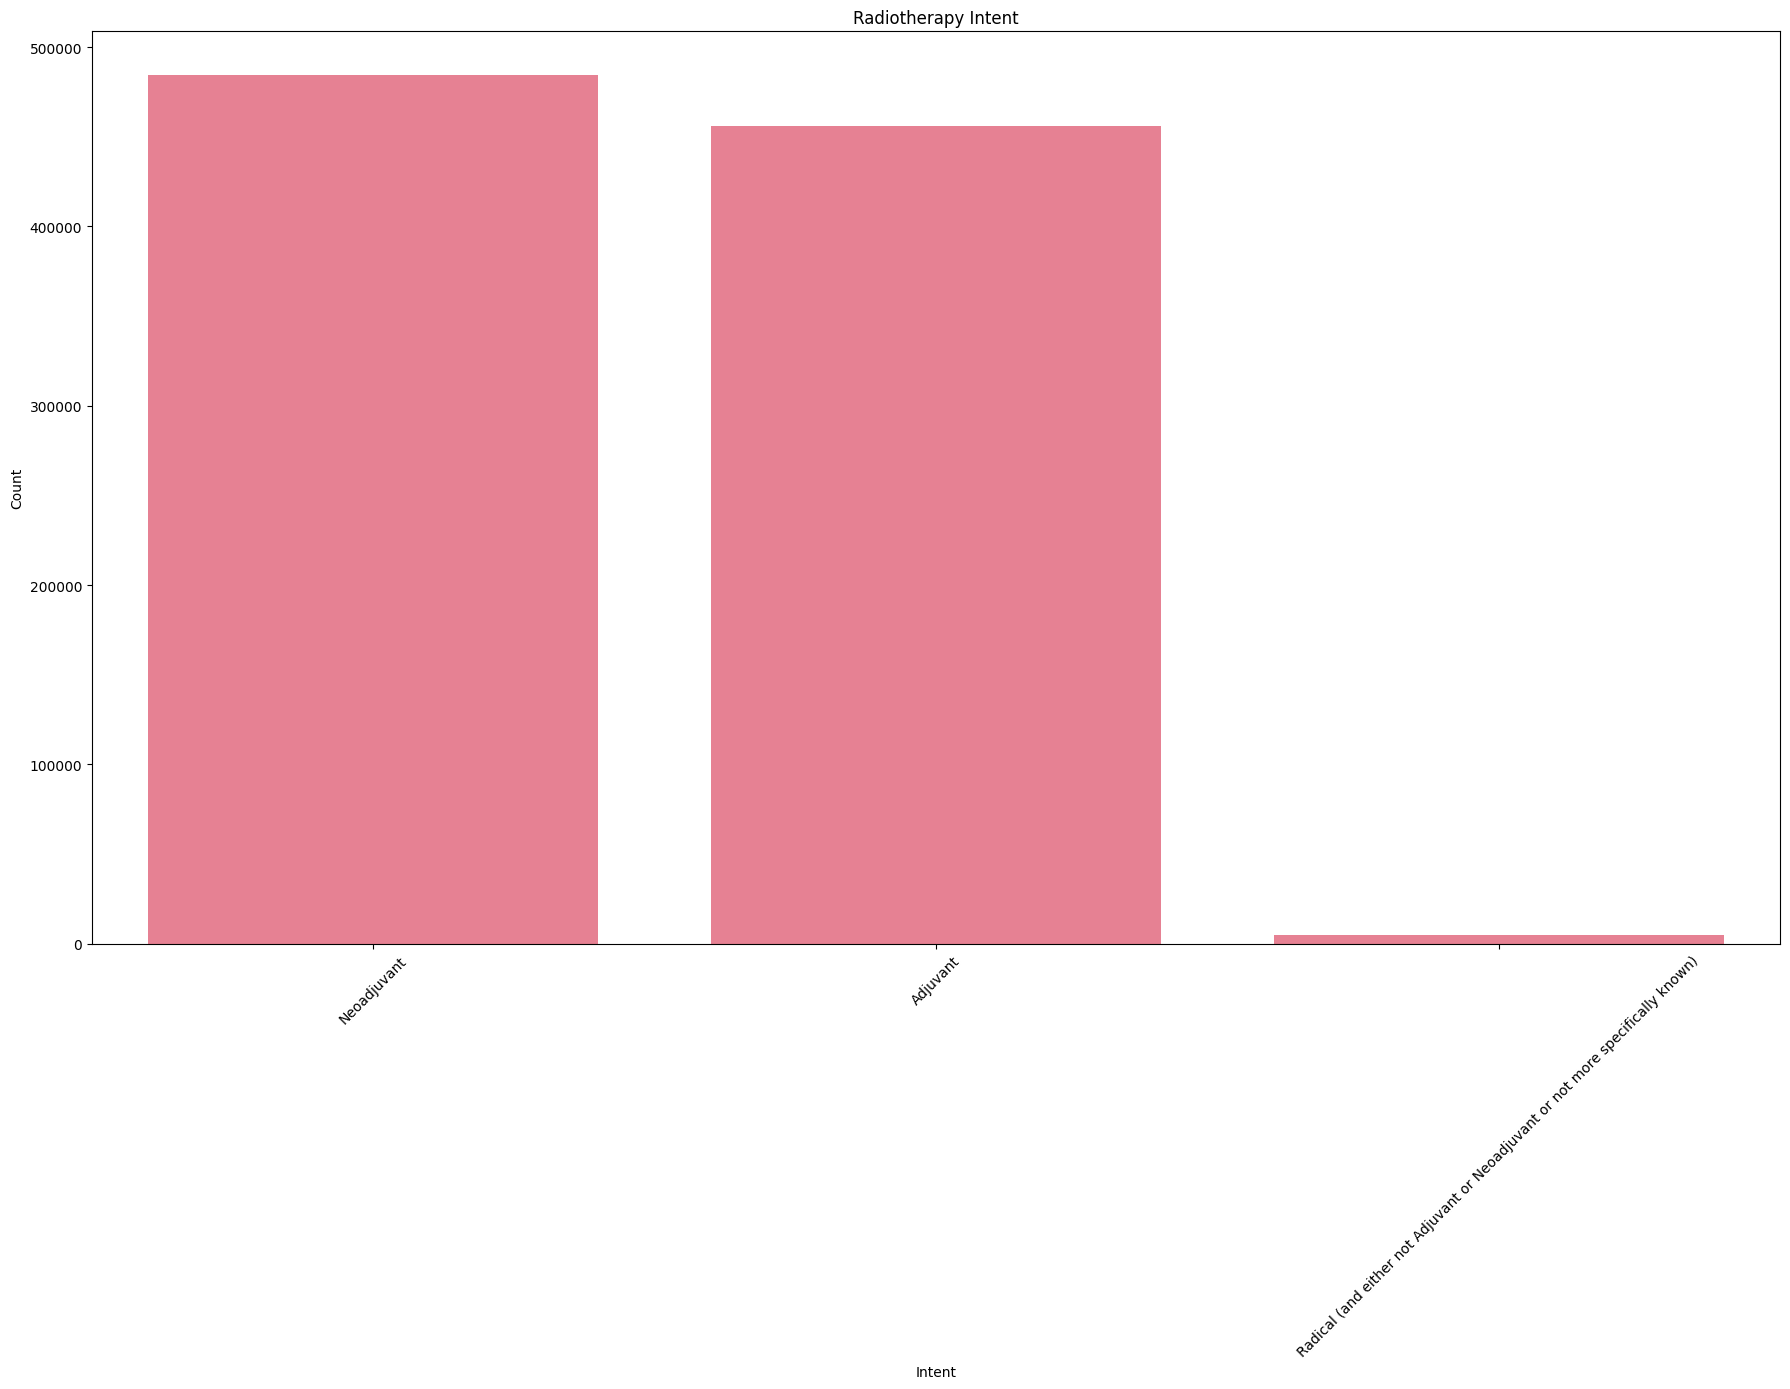

In [35]:
lung_rtds = rtds_df[rtds_df['PATIENTID'].isin(lung_patient_ids)]
lung_rtds = lung_rtds.merge(rt_intent_lookup, on='RADIOTHERAPYINTENT', how='left')
plot_counts(lung_rtds, 'rt_label', 'Radiotherapy Intent', 'Intent')

### Systemic Anti-Cancer Therapy (SACT) Uptake

In [36]:
sact_patients = sact_regimen_df['ENCORE_PATIENT_ID'].unique()
lung_tumours['received_sact'] = lung_tumours['PATIENTID'].isin(sact_patients)

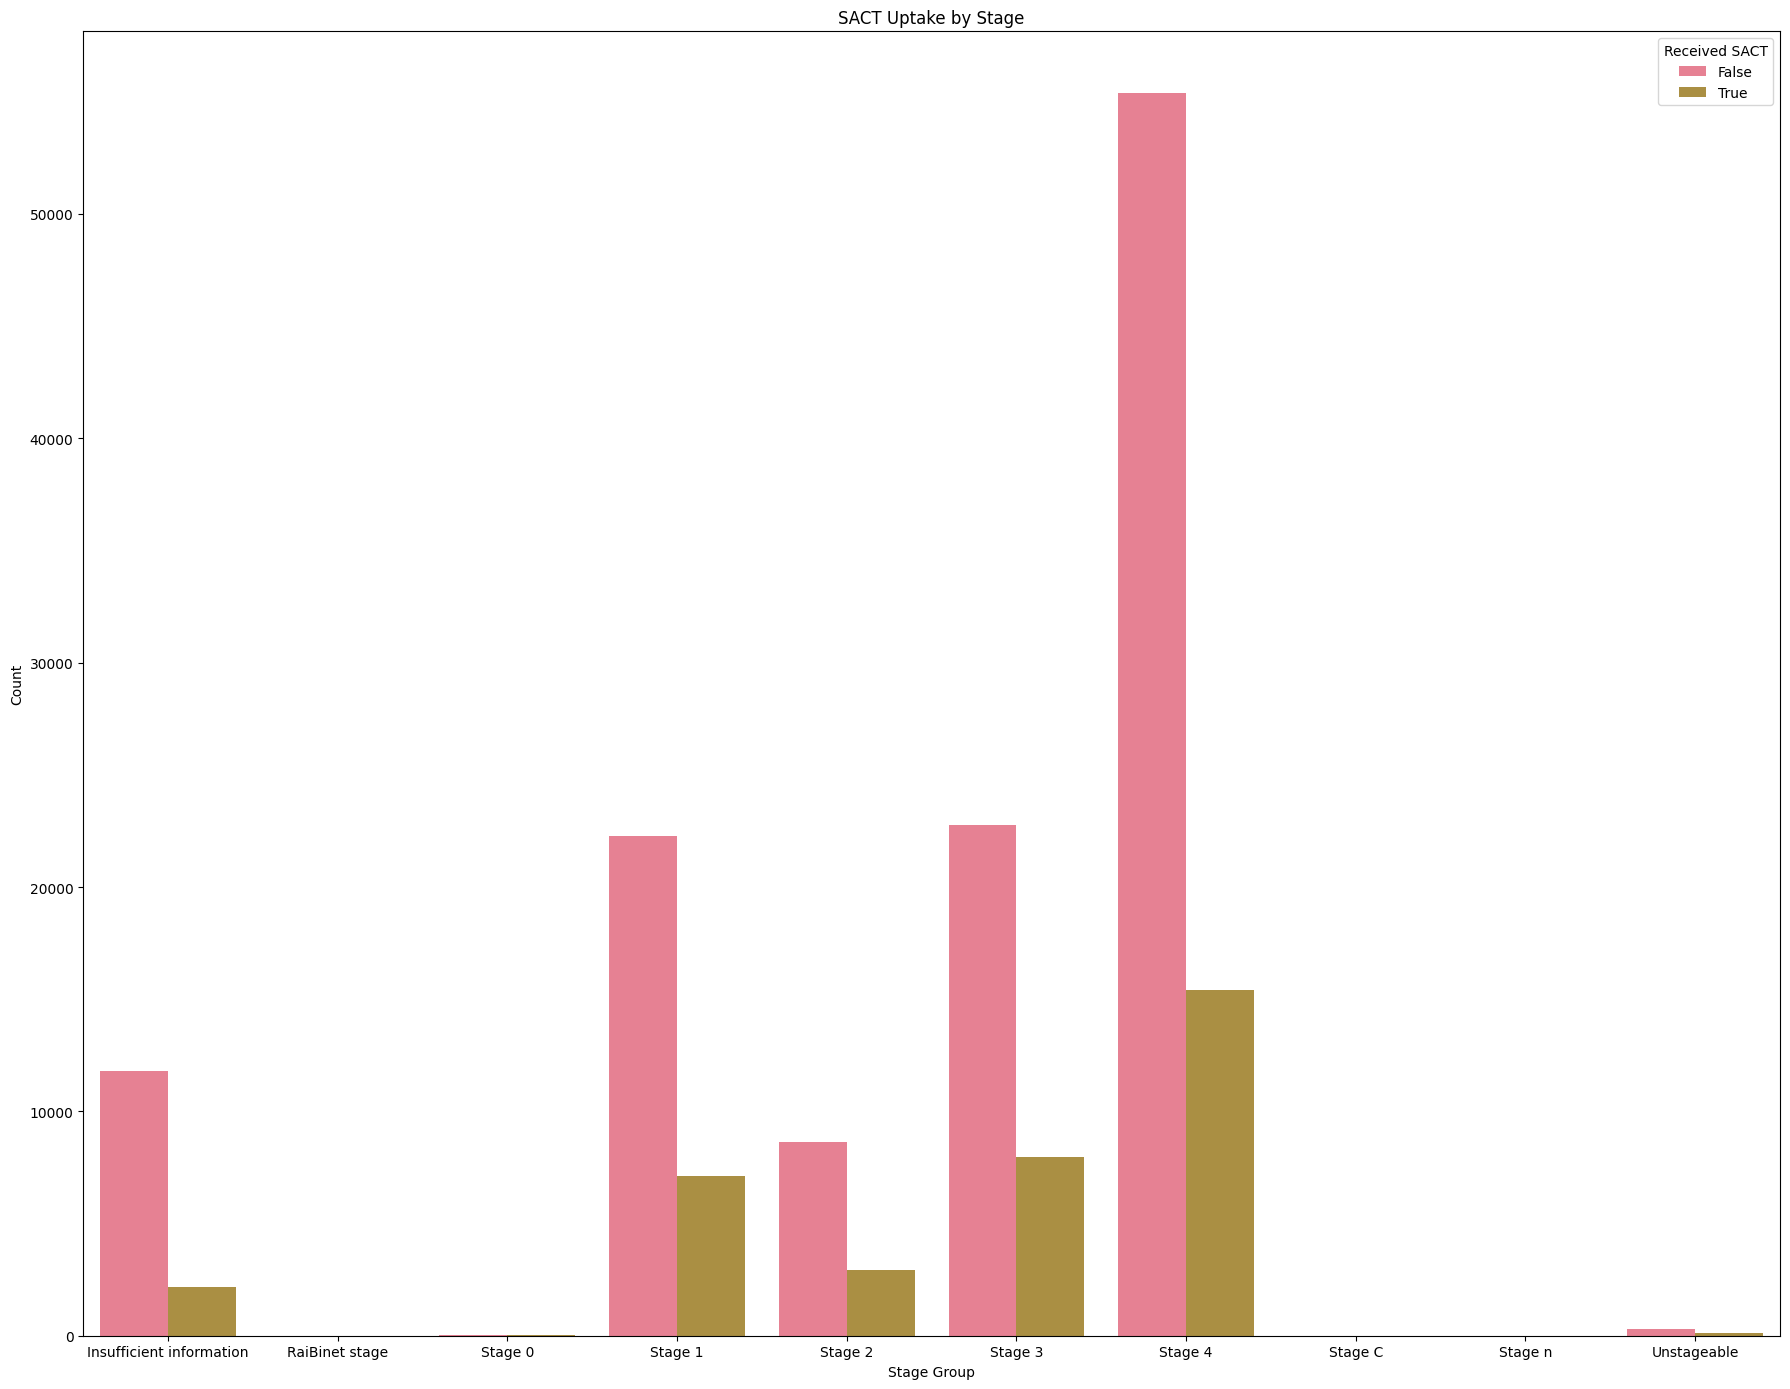

In [37]:
sns.countplot(data=lung_tumours, x='Stage_Group', hue='received_sact',
              order=sorted(lung_tumours['Stage_Group'].unique()))
plt.title("SACT Uptake by Stage")
plt.xlabel("Stage Group")
plt.ylabel("Count")
plt.legend(title="Received SACT")
plt.tight_layout()
plt.show()

### Gene Testing Analysis

In [38]:
tested_counts = gene_df.groupby('PATIENTID').size().rename('gene_tests')
surv_df = surv_df.merge(tested_counts, left_on='PATIENTID', right_index=True, how='left')
surv_df['gene_tests'] = surv_df['gene_tests'].fillna(0)
surv_df['tested_group'] = surv_df['gene_tests'].apply(lambda x: 'Tested' if x > 0 else 'Not Tested')

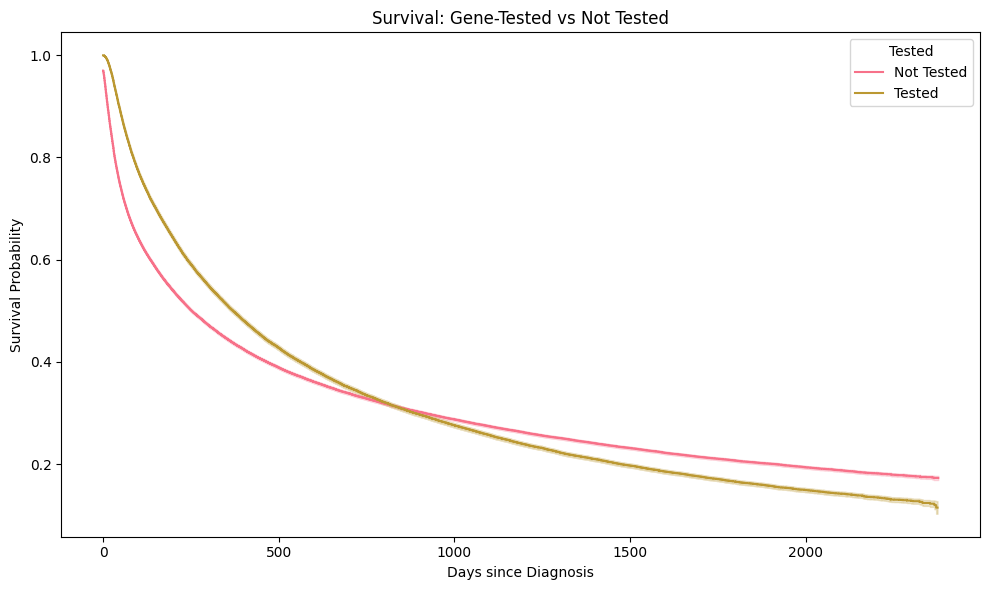

In [39]:
plt.figure(figsize=(10, 6))
for label, grp in surv_df.groupby('tested_group'):
    kmf.fit(grp['followup_days'], event_observed=grp['event_observed'], label=label)
    kmf.plot_survival_function()

plt.title("Survival: Gene-Tested vs Not Tested")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Survival Probability")
plt.legend(title="Tested")
plt.tight_layout()
plt.show()

### Death Rate by Stage

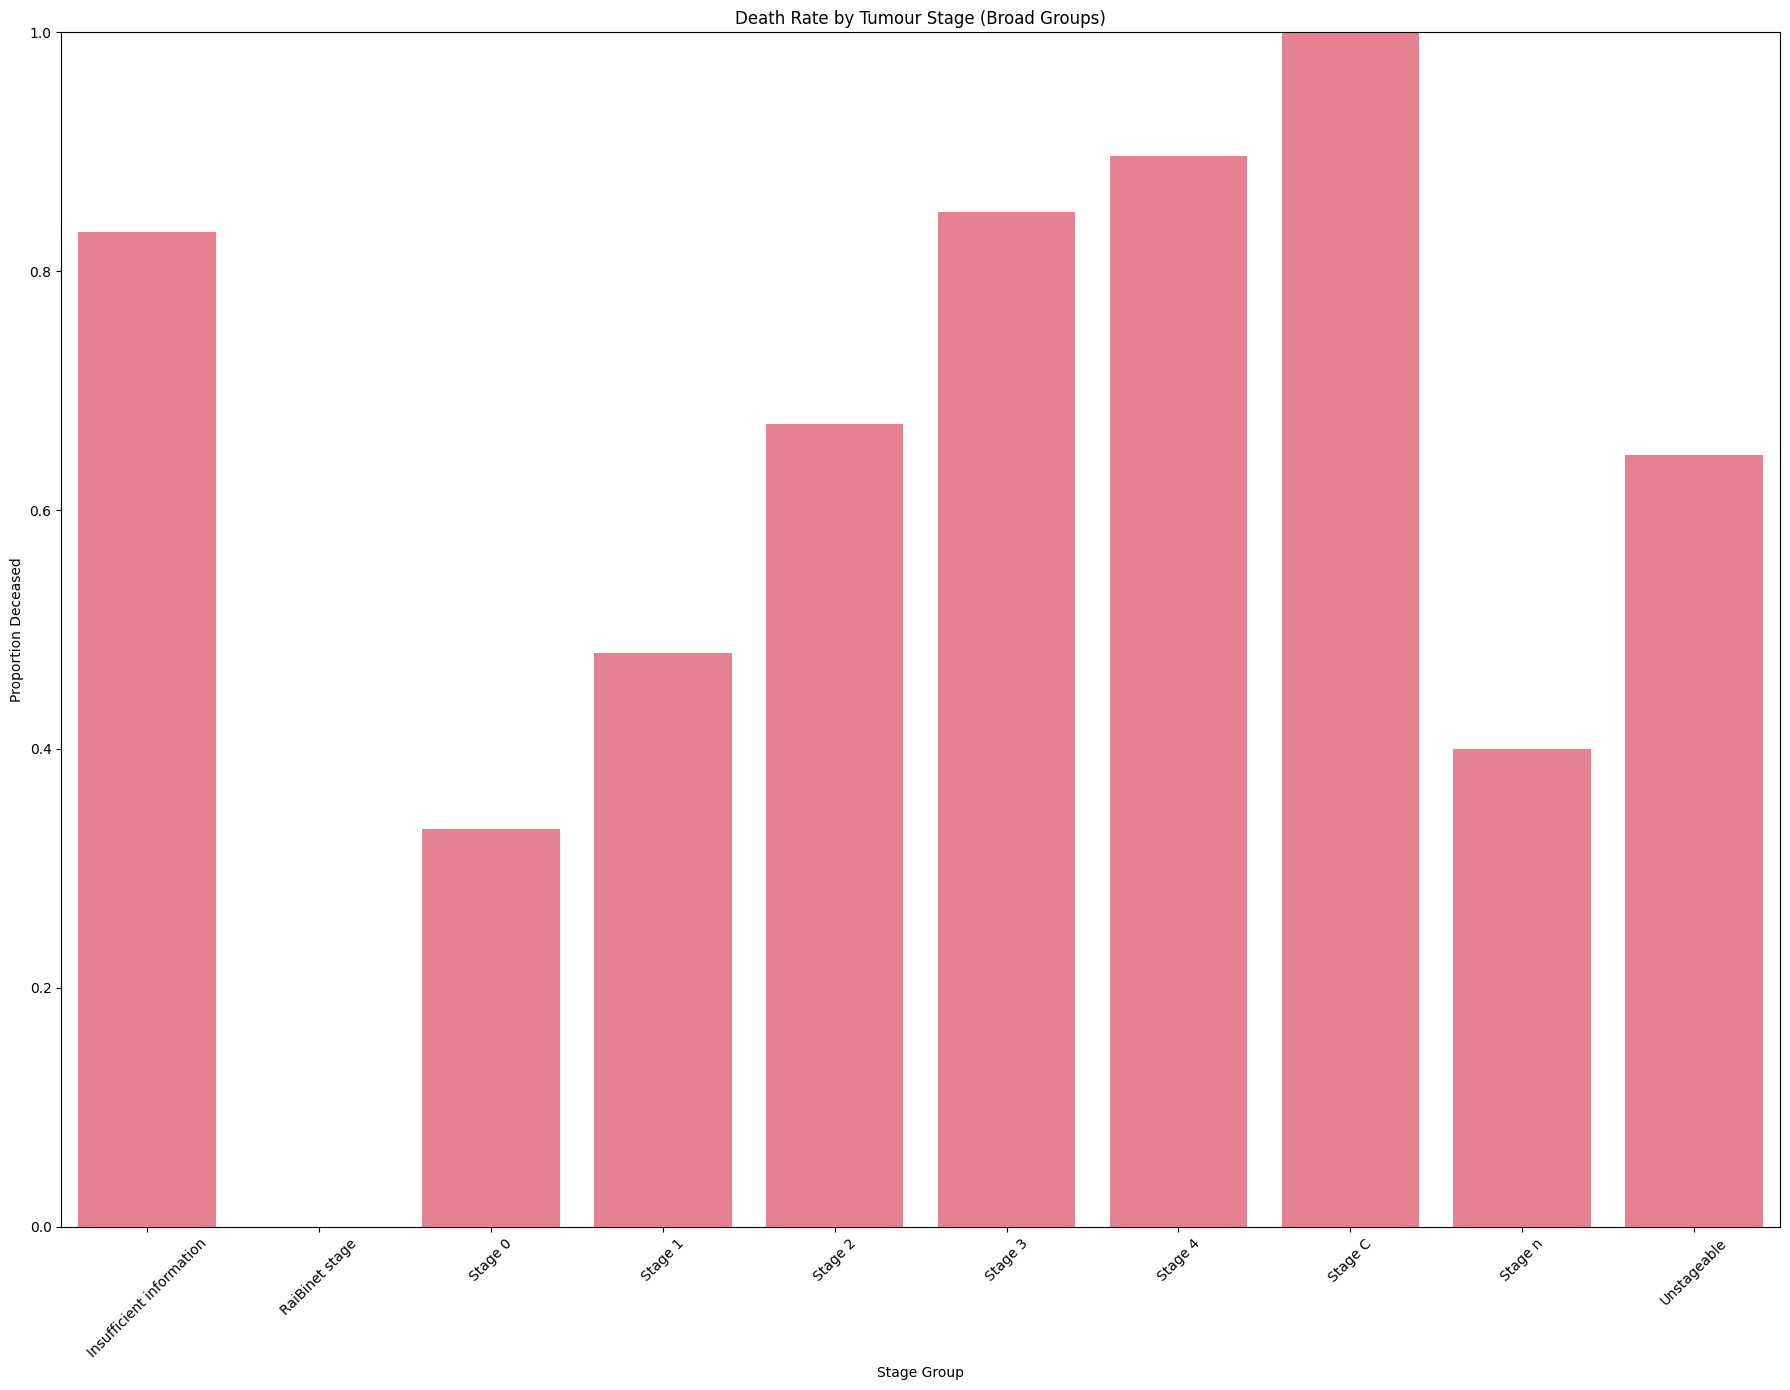

In [40]:
# Compute death rates by Stage_Group
death_by_stage = df_surv.groupby('Stage_Group')['event_observed'].mean().sort_index().reset_index()
death_by_stage.columns = ['Stage_Group', 'Death_Rate']

# Plot
sns.barplot(data=death_by_stage, x='Stage_Group', y='Death_Rate',
            order=death_by_stage['Stage_Group'])
plt.title("Death Rate by Tumour Stage (Broad Groups)")
plt.xlabel("Stage Group")
plt.ylabel("Proportion Deceased")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Follow-up Time Distribution by Stage & Event Status

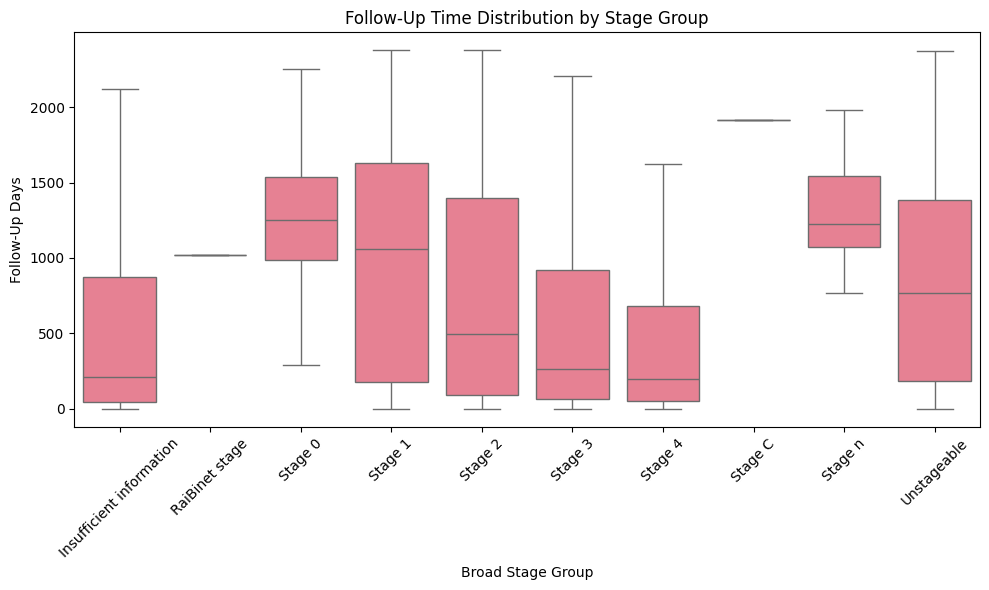

In [41]:
# Boxplot of follow-up days by Stage_Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_surv, x='Stage_Group', y='followup_days', showfliers=False,
            order=sorted(df_surv['Stage_Group'].unique()))
plt.title("Follow‑Up Time Distribution by Stage Group")
plt.xlabel("Broad Stage Group")
plt.ylabel("Follow-Up Days")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

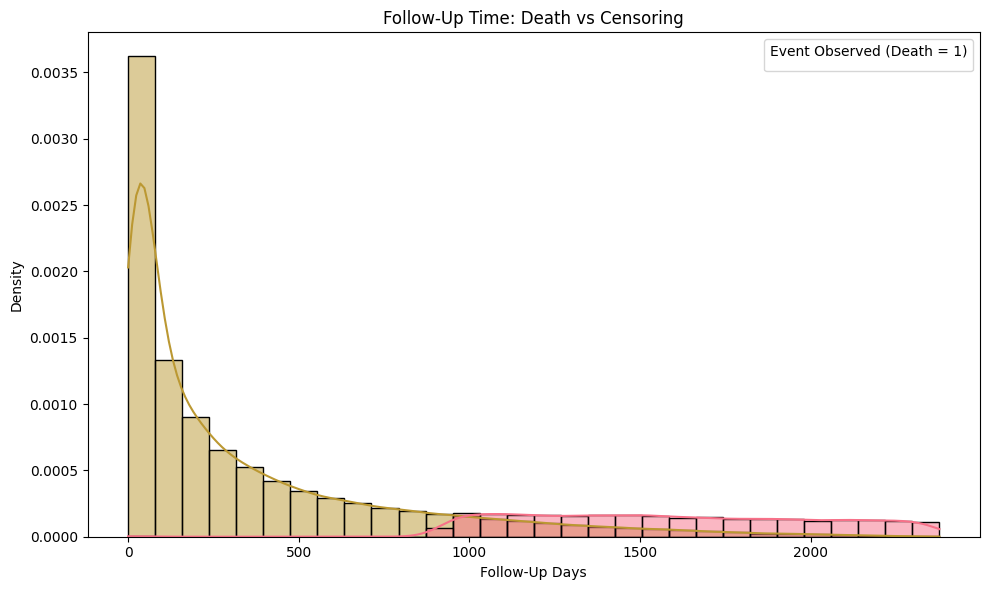

In [42]:
# Density plot of follow-up by event observed
plt.figure(figsize=(10, 6))
sns.histplot(data=df_surv, x='followup_days', hue='event_observed', bins=30,
             kde=True, stat="density")
plt.title("Follow‑Up Time: Death vs Censoring")
plt.xlabel("Follow-Up Days")
plt.ylabel("Density")
plt.legend(title="Event Observed (Death = 1)")
plt.tight_layout()
plt.show()

### Stacked Bar Chart: Survival Outcome by Ethnicity

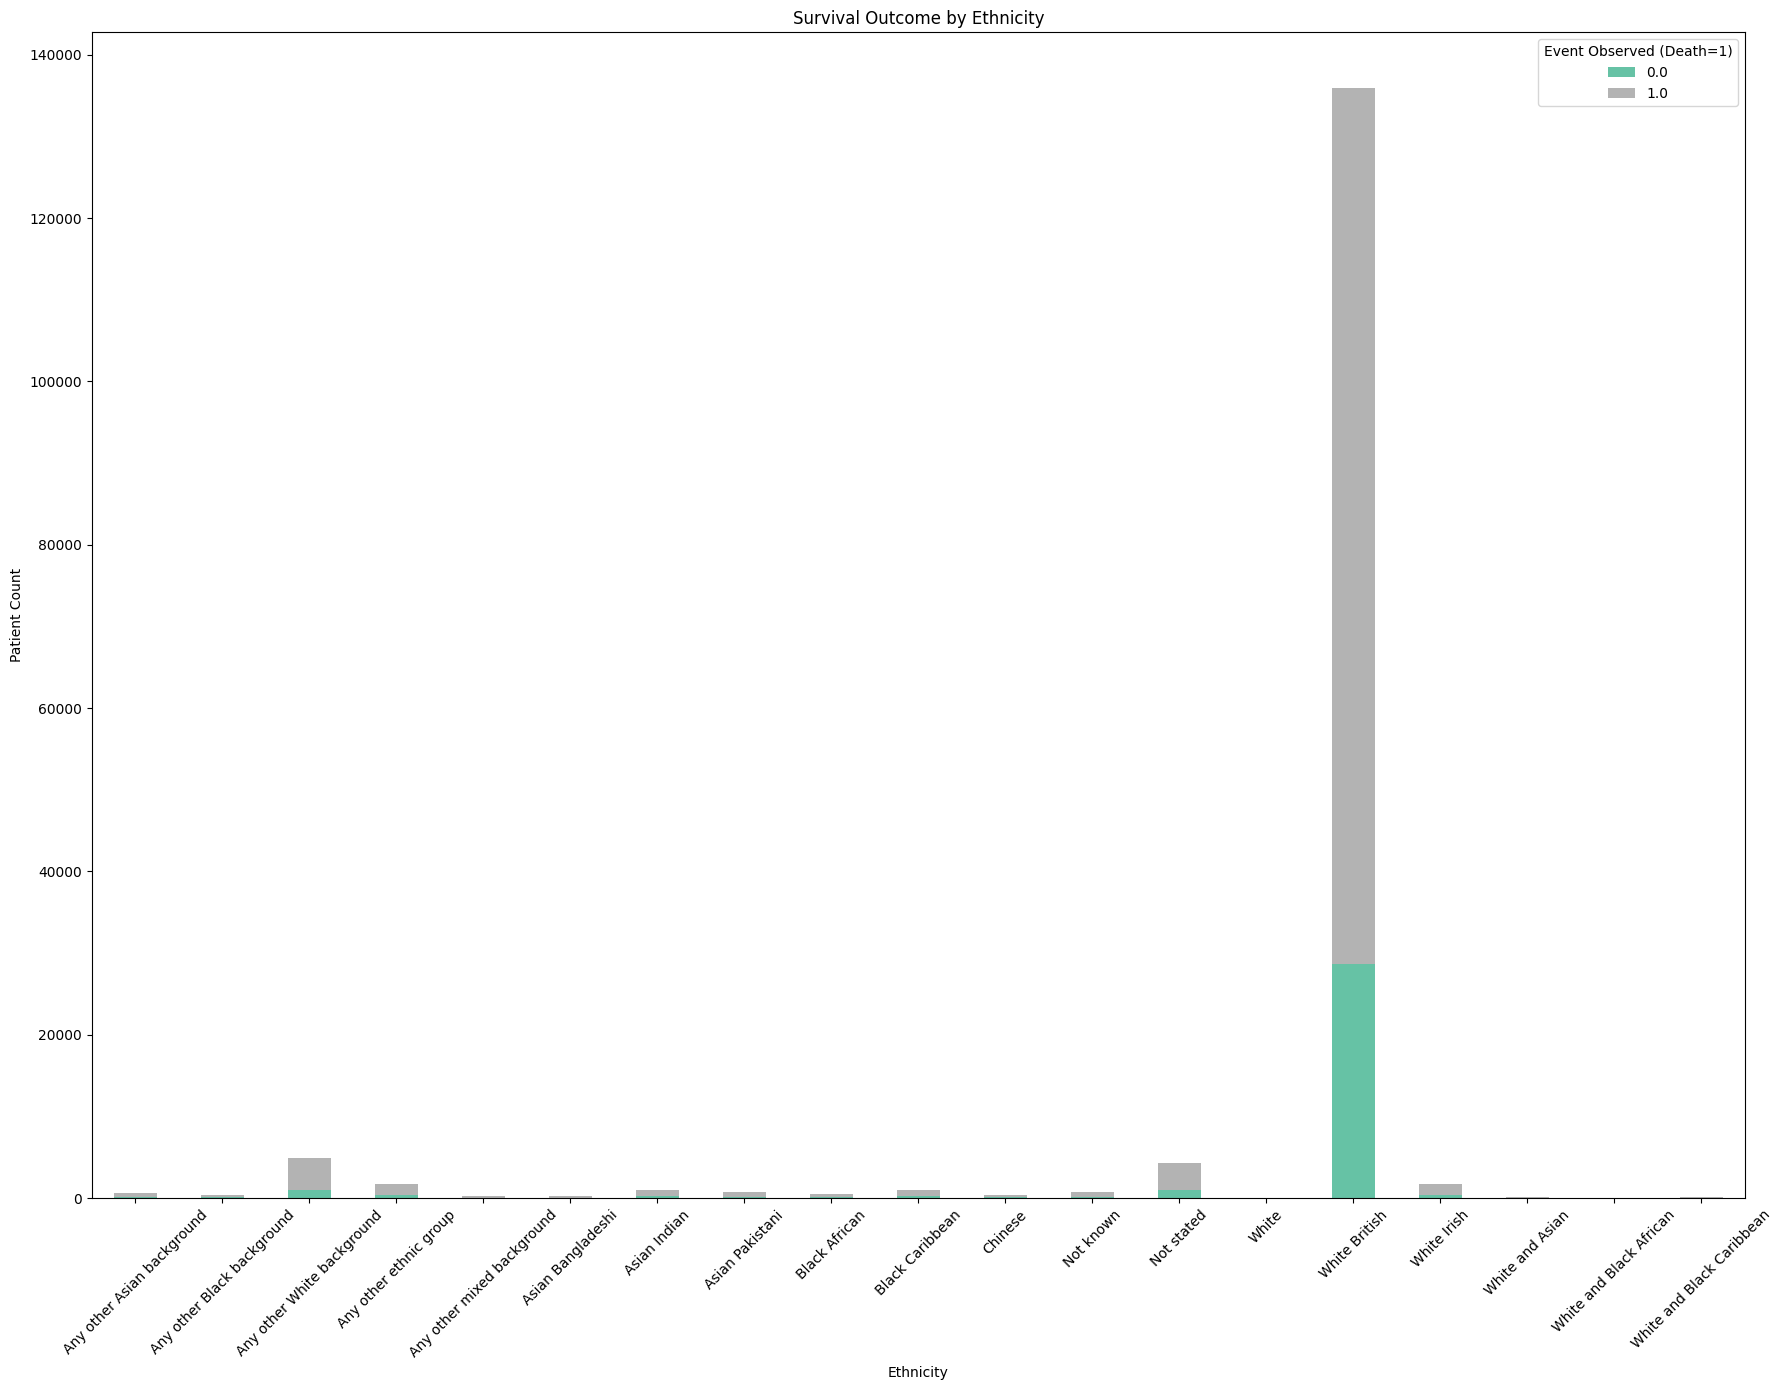

In [43]:
ethnicity_surv = lung_patients.merge(df[['PATIENTID', 'event_observed']], on='PATIENTID', how='left')
eth_counts = ethnicity_surv.groupby(['ethnicity_label', 'event_observed']).size().unstack().fillna(0)
eth_counts.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("Survival Outcome by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Patient Count")
plt.xticks(rotation=45)
plt.legend(title="Event Observed (Death=1)")
plt.tight_layout()
plt.show()

### SACT Uptake by Gender

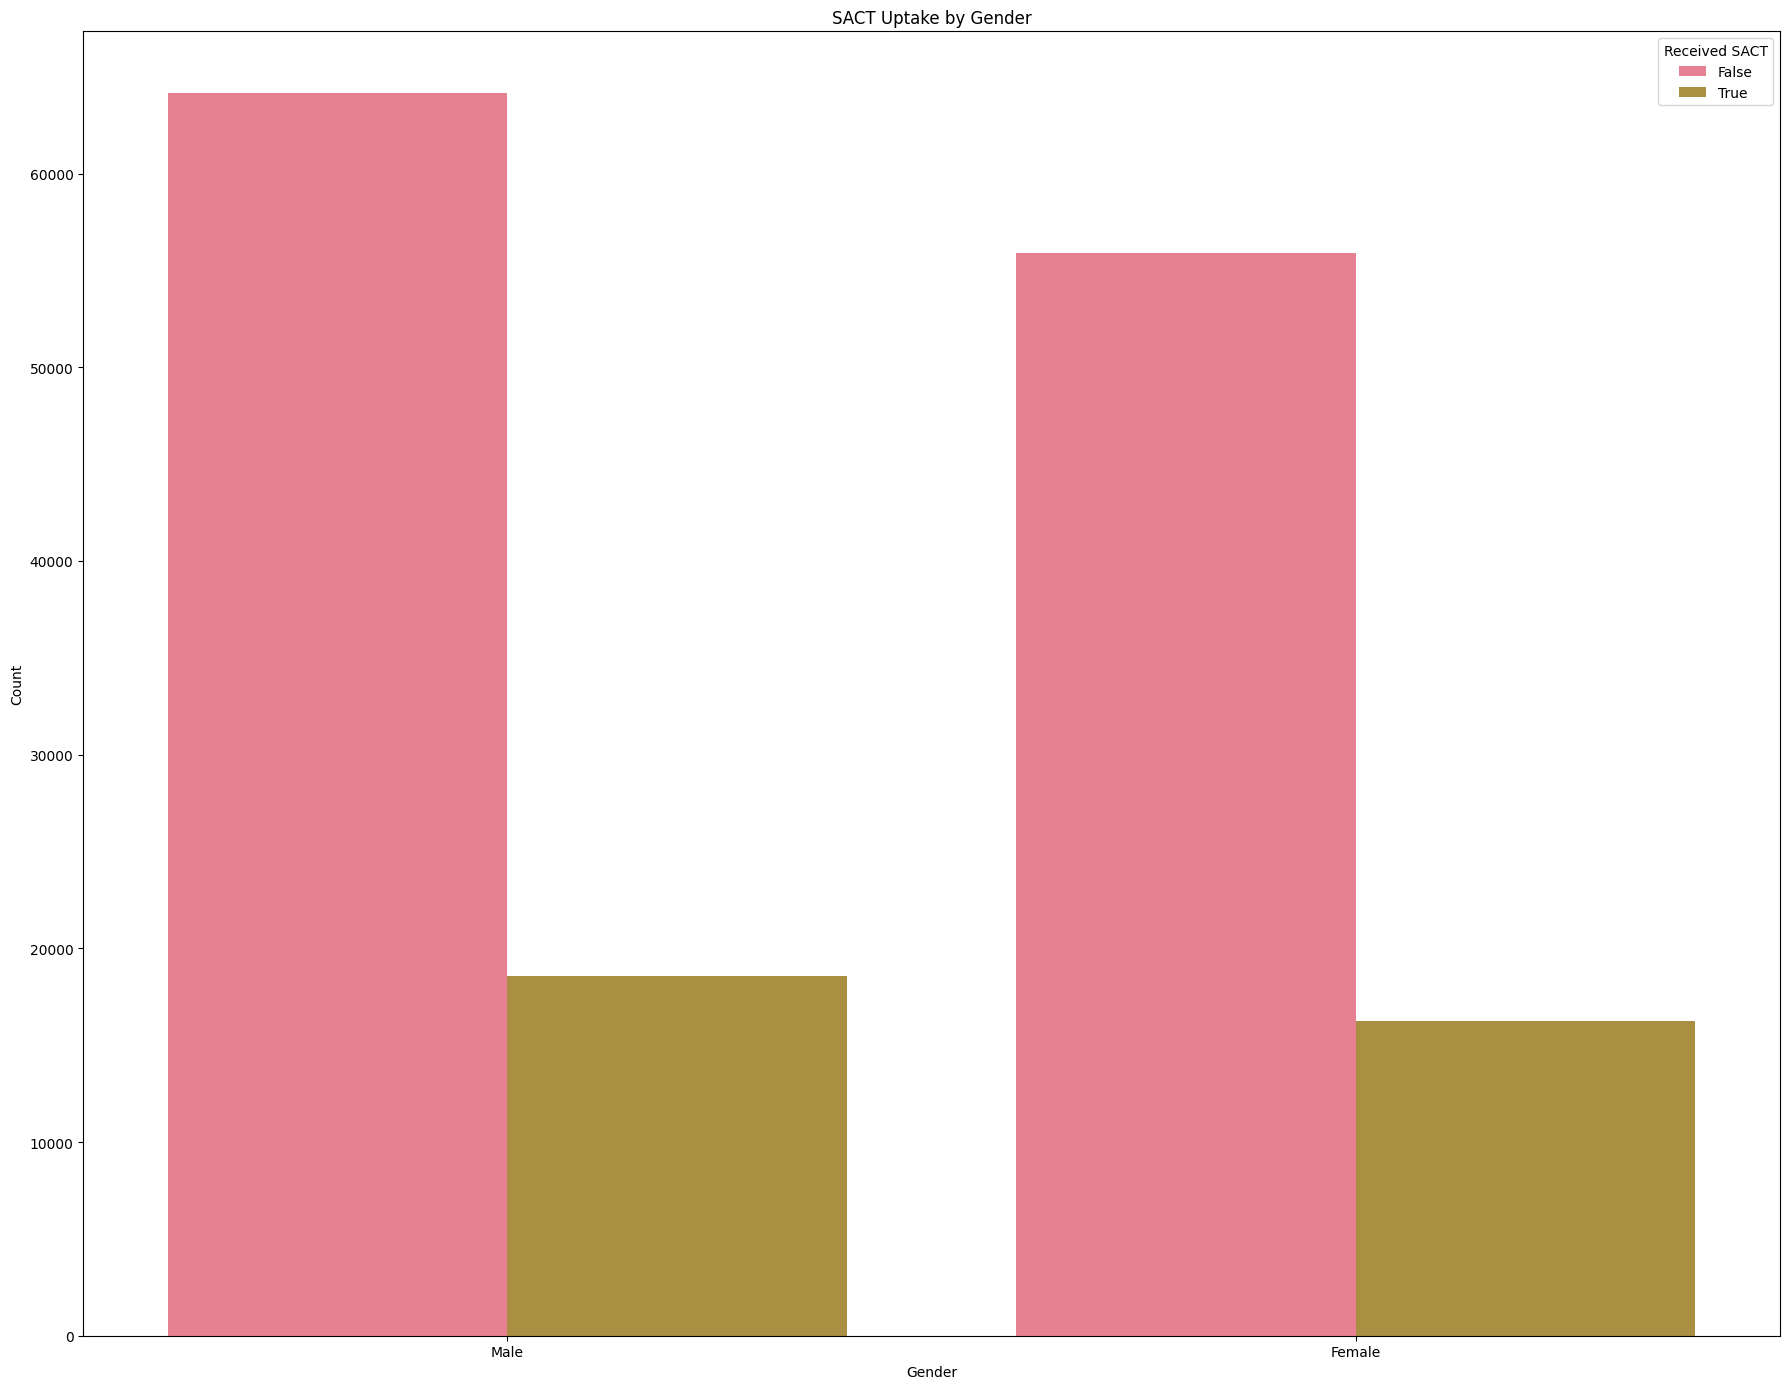

In [44]:
gender_sact = lung_patients.merge(stage_sact[['PATIENTID', 'received_sact']], on='PATIENTID', how='left')
sns.countplot(data=gender_sact, x='gender_label', hue='received_sact')
plt.title("SACT Uptake by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Received SACT")
plt.tight_layout()
plt.show()

### Kaplan–Meier Survival Curve

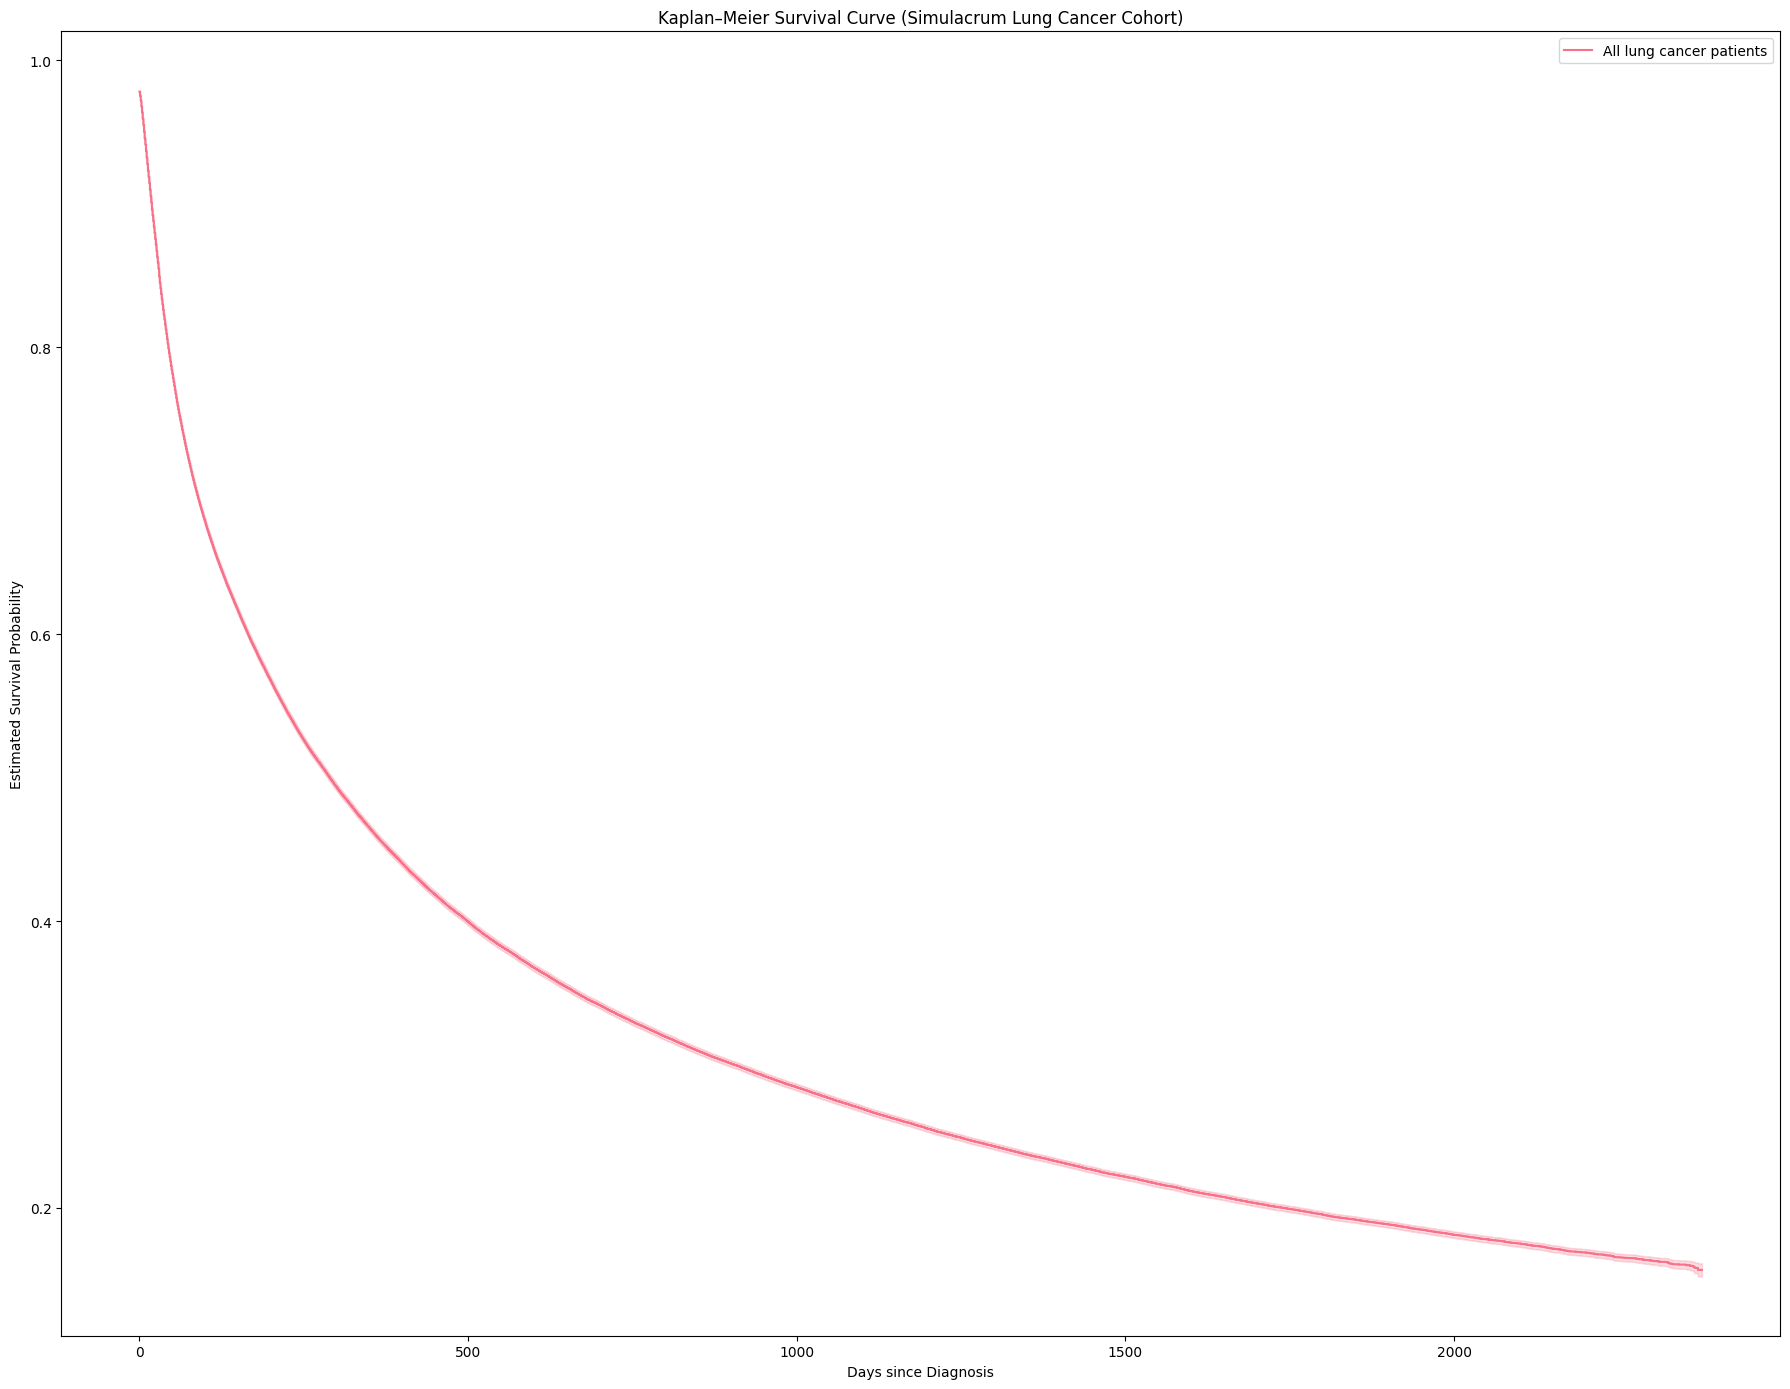

In [45]:
# Fit Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(df['followup_days'], event_observed=df['event_observed'], label="All lung cancer patients")

# Plot
kmf.plot(ci_show=True)
plt.title("Kaplan–Meier Survival Curve (Simulacrum Lung Cancer Cohort)")
plt.xlabel("Days since Diagnosis")
plt.ylabel("Estimated Survival Probability")
plt.tight_layout()
plt.show()

# Version TC C34

In [46]:
GROUP_8_PATH = '/content/drive/My Drive/Group8_TC_C34_v2_Data'

In [47]:
df_sim_av_patient = pd.read_csv(GROUP_8_PATH+'/sim_av_patient_c34.csv')

In [48]:
df_sim_av_patient.head()

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,VITALSTATUSDATE,LINKNUMBER
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101115525
1,10175273,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101155391
2,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,101574796
3,10175292,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,100834633
4,10175333,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2022-07-05,100951264


In [49]:
df_sim_av_gene = pd.read_csv(GROUP_8_PATH+'/sim_av_gene_c34.csv')

In [50]:
df_sim_av_gene.head()

,GENEID,TUMOURID,PATIENTID,GENE_DESC,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,ALL_TESTSTATUSES,OVERALL_TS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10037483,11641162,10243109,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-01-22,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,10037484,11723811,10243117,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2018-03-25,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,10037492,11502311,10243418,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-26,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,10037495,10073014,10243465,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-05-15,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,10037528,10014582,10244392,ROS1,67,1,1,1,NaN,g:unknown/null,...,NaN,2019-01-12,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [51]:
df_sim_av_gene.describe()

,GENEID,TUMOURID,PATIENTID,GENE,COUNT_TESTS,COUNT_RESULTS,COUNT_DATE,NO_OF_AB_GATS,NO_OF_SEQ_VARS,NO_OF_PRO_IMPS
count,1.006890e+05,1.006890e+05,1.006890e+05,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000,100689.000000
mean,1.006210e+08,1.100121e+07,1.005732e+08,1503.639126,1.092562,1.228913,1.058974,0.149947,0.034443,0.039567
std,1.189183e+07,5.785224e+05,1.189137e+07,2210.732603,0.424913,0.594973,0.333099,0.358188,0.202885,0.235377
min,1.003748e+07,1.000012e+07,1.017521e+07,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000248e+08,1.049507e+07,1.000084e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000618e+08,1.100333e+07,1.000194e+08,24.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.001025e+08,1.150246e+07,1.000291e+08,4842.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.500091e+08,1.199998e+07,2.500025e+08,5037.000000,23.000000,23.000000,23.000000,2.000000,4.000000,5.000000


In [52]:
df_patient_gene = pd.merge(df_sim_av_patient, df_sim_av_gene, on='PATIENTID', how='left')

In [53]:
df_patient_gene

,PATIENTID,GENDER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,VITALSTATUS,...,SEQ_VAR,DATE_OVERALL_TS,BEST_DATE_SOURCE_OVERALL_TS,MIN_DATE,MAX_DATE,ALL_PRO_IMPS,NO_OF_PRO_IMPS,PRO_IMP,METHODS,LAB_NAME
0,10175206,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,2019-11-09,1)authoriseddate,NaN,NaN,NaN,0.0,NaN,NaN,Bristol (molecular lab)
1,10175273,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,2017-08-07,1)authoriseddate,NaN,NaN,NaN,0.0,NaN,NaN,Newcastle (molecular lab)
3,10175282,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,2017-09-16,1)authoriseddate,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,10175292,1,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214784,250002505,2,A,C445,NaN,NaN,NaN,C809,1,D,...,NaN,2019-12-26,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
214785,250002507,2,A,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214786,250002519,2,J,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214787,250002530,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# Check the result
print(f"Original patient records: {len(df_sim_av_patient)}")
print(f"Original gene records: {len(df_sim_av_gene)}")
print(f"Combined records: {len(df_patient_gene)}")
print(f"Combined columns: {len(df_patient_gene.columns)}")

Original patient records: 157354
Original gene records: 100689
Combined records: 214789
Combined columns: 40


In [55]:
print(df_patient_gene.columns)

Index(['PATIENTID', 'GENDER', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
       'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'VITALSTATUS',
       'VITALSTATUSDATE', 'LINKNUMBER', 'GENEID', 'TUMOURID', 'GENE_DESC',
       'GENE', 'COUNT_TESTS', 'COUNT_RESULTS', 'COUNT_DATE',
       'ALL_TESTSTATUSES', 'OVERALL_TS', 'NO_OF_AB_GATS', 'DNASEQ_GAT',
       'METHYL_GAT', 'EXP_GAT', 'COPYNO_GAT', 'FUS_TRANS_GAT', 'ABNORMAL_GAT',
       'NO_OF_SEQ_VARS', 'ALL_SEQ_VARS', 'SEQ_VAR', 'DATE_OVERALL_TS',
       'BEST_DATE_SOURCE_OVERALL_TS', 'MIN_DATE', 'MAX_DATE', 'ALL_PRO_IMPS',
       'NO_OF_PRO_IMPS', 'PRO_IMP', 'METHODS', 'LAB_NAME'],
      dtype='object')
